# Advanced optimization - Homework 2

## 1. Dataset introduction
- Thông tin cá nhân:
  - EmployeeNumber: Mã Nhân viên
  - Gender: giới tính: Female/ Male
  - Age: Tuổi
  - MaritalStatus: Tình trạng hôn nhân, bao gồm các trạng thái
      - Unknown
      - Married
      - Divorced
      - Single
      - Widowed
  - Education: Cấp bậc học vấn, bao gồm 5 cấp bậc:
      - 1: Phổ thông trung học
      - 2: Trung cấp/ cao đẳng
      - 3: Đại học
      - 4: Thạc sỹ
      - 5: Tiến sỹ
  - EducationField: chuyên ngành giáo dục, bao gồm các phân loại chuyên ngành:
      - Kinh tế
      - Kỹ thuật
      - Công nghệ
      - Ngôn ngữ
      - Other
  - School: thông tin trường học
- Thông về công việc:
  - Department: đơn vị làm việc
  - jobCategory: phân ngành công việc
  - JobLevel: cấp bậc của nhân viên => yếu tố đánh giá thu nhập của nhân viên, chia thành 5 cấp bậc xếp hạng từ 1 --> 5 (với 5 là cấp bậc cao)
- Thông tin về hiệu suất và gắn bó:
  - PerformanceRating: đánh giá hiệu quả công việc trong 3 tháng gần nhất, xếp hạng từ 1 --> 5 (với 5 mà đánh giá tốt)
  - YearsAtCompany: thâm niên tại công ty
- Biến phụ thuộc:
  - Attrition: Yes/No => có nghỉ việc hay không

## 2. Setup

### 2.0 Install libraries

In [99]:
# !pip install numpy
# !pip install pandas
# !pip install xlrd
# !pip install openpyxl
# !pip install seaborn

### 2.1 Import libaries

In [100]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
import random
from enum import Enum
import time
import glob
import os
import ast
import scipy.special

import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action="ignore", category=DataConversionWarning)
random.seed(2)

### 2.2 Setup parameters

In [101]:
# FEATURES
# employee_number
# age                   : numerical
# department            : no oder categorical
# education             : order categorical
# school                : no oder categorical
# education_field       : no oder categorical
# gender                : no oder categorical
# job_level             : oder categorical
# job_title             : no oder categorical
# job_role              : no oder categorical
# job_category          : no oder categorical
# marital_status        : no oder categorical
# performance_rating    : order categorical
# years_at_company      : numerical

# OUTPUT
# attrition             : binary output

#### 2.2.1 Dataset parameters

In [102]:
DATASET_FILE_NAME = "hr_dataset.xlsx"
NUMERICAL_FEATURES = ["age", "years_at_company"]
ORDER_CATEGORICAL_FEATURES = ["education", "job_level", "performance_rating"]
NO_ORDER_CATEGORICAL_FEATURES = ["department", "school", "education_field", "gender", "job_category", "marital_status"]
OUTPUT_NAME = ["attrition"]

In [103]:
total_number_of_features = len(NUMERICAL_FEATURES) + len(ORDER_CATEGORICAL_FEATURES) + len(NO_ORDER_CATEGORICAL_FEATURES) + len(OUTPUT_NAME)
print("Total number of features: ", total_number_of_features)

Total number of features:  12


#### 2.2.2 GRADIENT DESCENT parameters

### 2.3 Import dataset

In [104]:
df = pd.read_excel(DATASET_FILE_NAME)

In [105]:
df

,Age,Department,Education,school,EducationField,Gender,JobLevel,jobCategory,MaritalStatus,PerformanceRating,YearsAtCompany,Attrition
0,30,FHO FWA,3,Đại học Duy Tân,Kỹ thuật,Male,4,BA,Single,3,3.169863,Yes
1,28,FI,3,Đại học Duy Tân,Công nghệ,Female,3,Tester,Single,3,6.049315,Yes
2,30,FHM,3,Đại học Huế - ĐH Khoa học,Công nghệ,Male,4,Engineer,Single,4,4.254795,Yes
3,28,FSG,3,Đại học Kinh tế quốc dân,Kinh tế,Female,3,BA,Single,3,3.835616,Yes
4,27,GST,3,Đại học Công nghệ Petronas,Công nghệ,Male,3,Engineer,Single,3,3.002740,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,31,SCM,3,Đại học Đà Nẵng - ĐH Sư phạm,Công nghệ,Male,3,Tester,Single,3,0.041096,No
4996,35,FQC,3,Đại học Kinh tế HCM,Kinh tế,Female,1,QA,Married,3,0.942466,No
4997,25,GST,3,Đại học QG Hà Nội-ĐH Công nghệ,Công nghệ,Male,1,Engineer,Single,3,1.372603,No
4998,25,FQC,3,Đại học Tôn Đức Thắng,Kinh tế,Male,2,QA,Single,3,1.191781,No


### 2.4 Overview of dataset

In [106]:
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def standardize_column_names(column_list):
    return [camel_to_snake(col) for col in column_list]

standardize_column_names(df.columns)

['age',
 'department',
 'education',
 'school',
 'education_field',
 'gender',
 'job_level',
 'job_category',
 'marital_status',
 'performance_rating',
 'years_at_company',
 'attrition']

In [107]:
df.columns = standardize_column_names(df.columns)

In [108]:
df.columns

Index(['age', 'department', 'education', 'school', 'education_field', 'gender',
       'job_level', 'job_category', 'marital_status', 'performance_rating',
       'years_at_company', 'attrition'],
      dtype='object')

<Axes: >

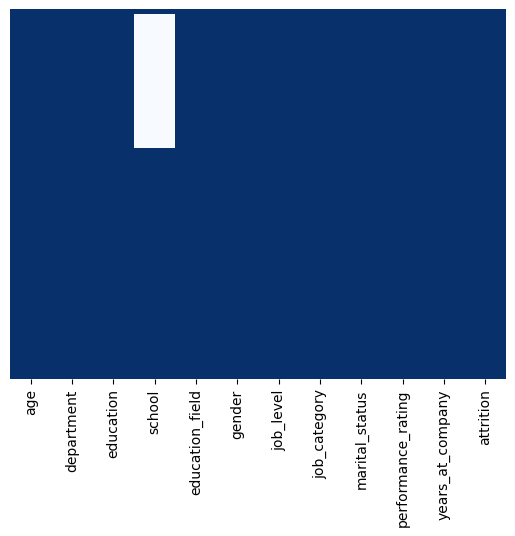

In [109]:
sns.heatmap(df.isnull(), cmap="Blues_r", cbar=False, yticklabels=False)

### 2.5 age

In [110]:
df["age"].describe()

count    5000.000000
mean       29.273800
std         4.876596
min        19.000000
25%        25.000000
50%        28.000000
75%        32.000000
max        54.000000
Name: age, dtype: float64

### 2.6 department

In [111]:
df["department"].describe()

count     4999
unique      57
top         FI
freq       651
Name: department, dtype: object

### 2.7 education

In [112]:
df["education"].describe()

count    5000.000000
mean        2.851800
std         0.509007
min         1.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: education, dtype: float64

## 3. Data cleaning

### 3.1 Data cleaning

In [113]:
# One hot encoding
cleaned_df = pd.get_dummies(df, columns=NO_ORDER_CATEGORICAL_FEATURES)

# Remove "employee_number"
cleaned_df = cleaned_df.iloc[:, 1:]

# Convert all boolean to integer
for col in cleaned_df.columns:
    if cleaned_df[col].dtype == np.bool_:
        cleaned_df[col] = cleaned_df[col].astype(int)

# Convert output
cleaned_df["attrition"] = cleaned_df["attrition"].map({"Yes": 1, "No": 0})

# Move output column to the last position
attrition_column = cleaned_df.pop("attrition")
cleaned_df = pd.concat([cleaned_df, attrition_column], axis=1)

cleaned_df

,education,job_level,performance_rating,years_at_company,department_AIC,department_CEP,department_DES,department_DPS,department_DXG,department_EBS,...,job_category_Others,job_category_PM,job_category_Product Engineering,job_category_QA,job_category_Tester,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown,attrition
0,3,4,3,3.169863,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,3,3,3,6.049315,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2,3,4,4,4.254795,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,3,3,3,3.835616,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,3,3,3,3.002740,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3,3,3,0.041096,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4996,3,1,3,0.942466,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4997,3,1,3,1.372603,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4998,3,2,3,1.191781,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


### 3.2 Data standardization

### 3.3 Summary X and y

In [114]:
X_df = cleaned_df.iloc[:,:-1]
X_df

,education,job_level,performance_rating,years_at_company,department_AIC,department_CEP,department_DES,department_DPS,department_DXG,department_EBS,...,job_category_Manager,job_category_Others,job_category_PM,job_category_Product Engineering,job_category_QA,job_category_Tester,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown
0,3,4,3,3.169863,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3,3,3,6.049315,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,3,4,4,4.254795,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,3,3,3.835616,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3,3,3,3.002740,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3,3,3,0.041096,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4996,3,1,3,0.942466,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4997,3,1,3,1.372603,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4998,3,2,3,1.191781,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [115]:
X = np.array(X_df).T
X

array([[3., 3., 3., ..., 3., 3., 3.],
       [4., 3., 4., ..., 1., 2., 2.],
       [3., 3., 4., ..., 3., 3., 3.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [116]:
X.shape

(358, 5000)

In [117]:
y_df = cleaned_df.iloc[:,-1]
y_df

0       1
1       1
2       1
3       1
4       1
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: attrition, Length: 5000, dtype: int64

In [118]:
y = np.array(y_df).reshape(-1, 1)
y

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [119]:
y.shape

(5000, 1)

### 3.4 Build Xbar (X and bias)

In [120]:
one = np.ones((1, X.shape[1]))
Xbar = np.concatenate((one, X), axis=0)
Xbar

array([[1., 1., 1., ..., 1., 1., 1.],
       [3., 3., 3., ..., 3., 3., 3.],
       [4., 3., 4., ..., 1., 2., 2.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [121]:
Xbar.shape

(359, 5000)

## 4. Build the models

### Requirements
- Neccessary features
- Best link functions

### 4.1. The simplest model

In [122]:
# y = f(w^Tx)

# f(s) = 1 / (1 + e^-s)     (logit link function)

In [123]:
def sigmoid(x):
    return scipy.special.expit(x)

## 5. Algorithms optimization

### 5.1. Loss function selection

In [124]:
"""
z = b + w * x

y^ = 1 / (1 + e^-z) (sigmoid link function)

cost(y^, y) = -1 * (y * log(y^) + (1 - y) * log(1 - y^))

Conclusion: cost(y^, y) = 1/N * - (y^T * log(y^) + (1 - y)^T * log(1 - y^))

"""

'\nz = b + w * x\n\ny^ = 1 / (1 + e^-z) (sigmoid link function)\n\ncost(y^, y) = -1 * (y * log(y^) + (1 - y) * log(1 - y^))\n\nConclusion: cost(y^, y) = 1/N * - (y^T * log(y^) + (1 - y)^T * log(1 - y^))\n\n'

In [125]:
def cost(w: np.ndarray, Xbar: np.ndarray, y: np.ndarray):
    # w is a vector that includes the bias
    w = w.reshape(-1, 1)
    N = Xbar.shape[1]
    y_hat = sigmoid(Xbar.T.dot(w))
    
    return 1 / N * -(y.T.dot(np.log(y_hat)) + (1 - y).T.dot(np.log(1 - y_hat)))

In [126]:
"""
cost(y^, y) = 1/N * - (y * log(y^) + (y - 1) * log(1 - y^))

Let A = y * log(y^)

Let B = (y - 1) * log(1 - y^)


Find dA/dw

dA/dw 
= d(y * log(y^)) / dw
= y * 1 / y^ * (dy^/dw)
= y * 1 / y^ * (dy^/dz * dz/dw)
= y * 1 / y^ * ((1 - y^) * y^ * x)
= y * (1 - y^) * x


Find dB/dw

dB/dw
= d((1 - y) * log(1 - y^)) / dw
= (1 - y) / (1 - y^) * (dy^/dw)
= (1 - y) / (1 - y^) * (dy^/dz * dz/dw)
= (1 - y) / (1 - y^) * ((1 - y^) * y^ * x)
= (1 - y) * y^ * x

=> gradient(y^, y)
= dA/dw + dB/dw
= y * (1 - y^) * x + (1 - y) * y^ * x
= x * (y^ - y)

Conclusion: gradient(y^, y) = x * (y^ - y)

"""

'\ncost(y^, y) = 1/N * - (y * log(y^) + (y - 1) * log(1 - y^))\n\nLet A = y * log(y^)\n\nLet B = (y - 1) * log(1 - y^)\n\n\nFind dA/dw\n\ndA/dw \n= d(y * log(y^)) / dw\n= y * 1 / y^ * (dy^/dw)\n= y * 1 / y^ * (dy^/dz * dz/dw)\n= y * 1 / y^ * ((1 - y^) * y^ * x)\n= y * (1 - y^) * x\n\n\nFind dB/dw\n\ndB/dw\n= d((1 - y) * log(1 - y^)) / dw\n= (1 - y) / (1 - y^) * (dy^/dw)\n= (1 - y) / (1 - y^) * (dy^/dz * dz/dw)\n= (1 - y) / (1 - y^) * ((1 - y^) * y^ * x)\n= (1 - y) * y^ * x\n\n=> gradient(y^, y)\n= dA/dw + dB/dw\n= y * (1 - y^) * x + (1 - y) * y^ * x\n= x * (y^ - y)\n\nConclusion: gradient(y^, y) = x * (y^ - y)\n\n'

In [127]:
def grad(w: np.ndarray, Xbar: np.ndarray, y: np.ndarray):
    # w is a vector that includes the bias
    w = w.reshape(-1, 1)
    N = Xbar.shape[1]
    y_hat = sigmoid(Xbar.T.dot(w))
    
    return Xbar.dot(y_hat - y) / N

In [128]:
"""
gradient_2(y^, y) 
= 1 / N * X^T * R * X

with R is diagonal matrix with Rii = y_hat(x^(i))(1 - y_hat(x^(i)))

"""

'\ngradient_2(y^, y) \n= 1 / N * X^T * R * X\n\nwith R is diagonal matrix with Rii = y_hat(x^(i))(1 - y_hat(x^(i)))\n\n'

In [129]:
def grad_2(w: np.ndarray, Xbar: np.ndarray, y: np.ndarray):
    # w is a vector that includes the bias
    w = w.reshape(-1, 1)
    N = Xbar.shape[1]
    y_hat = sigmoid(Xbar.T.dot(w))
    R = np.diag(y_hat.flatten() * (1 - y_hat.flatten()))

    return Xbar.dot(R).dot(Xbar.T) / N

### 5.2. Double check gradient using numerical gradient

In [130]:
def check_grad(fn, gr, X, Xbar: np.ndarray, y: np.ndarray):
    # convert X to an 1d array, later we'll need only one for loop
    X_flat = X.ravel()
    shape_X = X.shape  # original shape of X
    num_grad = np.zeros_like(X)  # numerical grad, shape = shape of X
    grad_flat = np.zeros_like(X_flat)  # 1d version of grad
    eps = 1e-10  # a small number, 1e-10 -> 1e-6 is often good
    numElems = X_flat.shape[0]  # number of elements in X
    # calculate numerical gradient
    for i in range(numElems):  # iterate over all elements of X
        Xp_flat = X_flat.copy()
        Xn_flat = X_flat.copy()
        Xp_flat[i] += eps
        Xn_flat[i] -= eps
        Xp = Xp_flat.reshape(shape_X)
        Xn = Xn_flat.reshape(shape_X)
        fp_ = fn(Xp, Xbar, y)
        fn_ = fn(Xn, Xbar, y)
        grad_flat[i] = (fp_.item() - fn_.item()) / (2 * eps)

    num_grad = grad_flat.reshape(shape_X)

    diff = np.linalg.norm(num_grad.reshape(-1, 1) - gr(X, Xbar, y).reshape(-1, 1))
    print("Difference between two methods should be small:", diff)


# check_grad(cost, grad, np.array([0] * Xbar.shape[0]), Xbar, y)

In [131]:
# check_grad(cost, grad, np.array([0.1] * Xbar.shape[0]), Xbar, y)

check_grad(cost, grad, np.random.randn(Xbar.shape[0]), Xbar, y)

Difference between two methods should be small: 0.015619636701259973


### 5.3. Core functions

In [132]:
W_EPOCH = []
EPOCH_COUNT = []
LOSS_VALUE_EPOCH = []
TIME_EACH_EPOCH = []


def reset_list():
    global W_EPOCH, EPOCH_COUNT, LOSS_VALUE_EPOCH, TIME_EACH_EPOCH

    W_EPOCH = []
    EPOCH_COUNT = []
    LOSS_VALUE_EPOCH = []
    TIME_EACH_EPOCH = []


class AlgorithmType(Enum):
    """Enumeration for different algorithm types with optional parameters."""

    # INCLUDED ADDITIONAL PARAMETERS

    # GRADIENT_DESCENT =================================================

    GRADIENT_DESCENT_FIX_LEARNING_RATE = {}
    """Gradient Descent with a fixed learning rate. No additional parameters."""

    GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE = {"alpha": 1 / 4, "beta": 1 / 2}
    """Gradient Descent with backtracking line search.
    
    Parameters:
        alpha: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
        beta: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
    """

    # STOCHASTIC_GRADIENT_DESCENT ======================================

    STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE = {
        "batch_size": 1,
        "rule": 0,
        "random_seed": 10,
    }
    """Stochastic Gradient Descent with a diminishing learning rate.

    Parameters:
        batch_size: number of data points each training. Range: [0, N]. Default: 1
        rule: 0 is Randomized rule, 1 is Cyclic rule. Range: {0, 1}. Default: 0
        random_seed: Random number generator seed. Default: 10
    """

    STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE = {
        "batch_size": 1,
        "rule": 0,
        "random_seed": 10,
        "alpha": 1 / 4,
        "beta": 1 / 2,
    }
    """Stochastic Gradient Descent with a backtracking diminishing learning rate.

    Parameters:
        batch_size: number of data points each training. Range: [0, N]. Default: 1
        rule: 0 is Randomized rule, 1 is Cyclic rule. Range: {0, 1}. Default: 0
        random_seed: Random number generator seed. Default: 10
        alpha: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
        beta: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
    """

    # MOMENTUM_GRADIENT_DESCENT ========================================

    MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE = {"gamma": 0.9}
    """Momentum Gradient Descent with a fixed learning rate.

    Parameters:
        gamma: weight of previous velocity.
    """

    MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE = {
        "gamma": 0.9,
        "alpha": 1 / 4,
        "beta": 1 / 2,
    }
    """Momentum Gradient Descent with backtracking line search.

    Parameters:
        gamma: Weight of previous velocity. Range: (0.0, 1.0). Default: 0.9
        alpha: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
        beta: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
    """

    # NESTEROV_GRADIENT_DESCENT ========================================

    NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE = {"NAG_gamma": 0.9}
    """Nesterov Gradient Descent with a fixed learning rate.

    Parameters:
        gamma: Weight of previous velocity. Range: (0.0, 1.0). Default: 0.9
    """

    NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE = {
        "NAG_gamma": 0.9,
        "alpha": 1 / 4,
        "beta": 1 / 2,
    }
    """Nesterov Gradient Descent with backtracking line search.

    Parameters:
        gamma: Weight of previous velocity. Range: (0.0, 1.0). Default: 0.9
        alpha: The factor by which the step size is multiplied. Range: (0, 0.5]. Default: 0.25
        beta: The fraction of the decrease in the function value. Range: (0.0, 1.0). Default: 0.5
    """

    NEWTON = {"test": 1}
    """Newton algorithm
    
    Parameters:
        test: to distinguish with GRADIENT_DESCENT_FIX_LEARNING_RATE
    """


# GRADIENT_DESCENT_FIX_LEARNING_RATE
def gradient_descent_fix_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)

    W_EPOCH = [w0]
    EPOCH_COUNT = [1]
    TIME_EACH_EPOCH = [0]

    start_time = time.time()

    for epoch in range(max_epochs):

        w_new = W_EPOCH[-1] - learning_rate * grad(W_EPOCH[-1], Xbar, y)

        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break

        W_EPOCH.append(w_new)
        EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
        TIME_EACH_EPOCH.append(time.time() - start_time)


# GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
def gradient_descent_backtracking_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)

    # Additional parameters
    alpha = additional_parameters["alpha"]
    beta = additional_parameters["beta"]

    W_EPOCH = [w0]
    EPOCH_COUNT = [1]
    TIME_EACH_EPOCH = [0]

    start_time = time.time()

    for epoch in range(max_epochs):

        learning_rate = initial_learning_rate

        # BACKTRACKING =================================================

        # At each iteration, start with lr = lr_init, and while
        #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||grad(x)||_2^2 (squared of 2-norm)
        #           => t = beta * t
        # else
        # perform gradient descent update
        #           w_new = last_w - lr * grad(x)

        last_w = W_EPOCH[-1]
        left_hand_side = cost(last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y)
        right_hand_side = cost(
            last_w, Xbar, y
        ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        while left_hand_side > right_hand_side:
            # Update learning rate
            learning_rate = beta * learning_rate

            left_hand_side = cost(
                last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
            )
            right_hand_side = cost(
                last_w, Xbar, y
            ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        # ==============================================================

        w_new = W_EPOCH[-1] - learning_rate * grad(W_EPOCH[-1], Xbar, y)

        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break

        W_EPOCH.append(w_new)
        EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
        TIME_EACH_EPOCH.append(time.time() - start_time)


# STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
def stochastic_gradient_descent_diminishing_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    batch_size = (
        additional_parameters["batch_size"]
        if additional_parameters["batch_size"] > 0
        else 1
    )
    rule = (
        additional_parameters["rule"] if additional_parameters["rule"] in [0, 1] else 0
    )
    random_seed = additional_parameters["random_seed"]

    random.seed(random_seed)

    # Randomized rule
    if rule == 0:

        # w0 is a vector that included the bias
        w0 = w0.reshape(-1, 1)

        W_EPOCH = [w0]
        EPOCH_COUNT = [1]
        TIME_EACH_EPOCH = [0]

        start_time = time.time()

        for epoch in range(max_epochs):
            all_indexes = list(range(Xbar.shape[1]))
            selected_indexes = []
            iteration = 0
            w_each_iteration = [W_EPOCH[-1]]

            while len(all_indexes) > 0:
                iteration += 1

                if batch_size < len(all_indexes):
                    selected_indexes = random.sample(all_indexes, batch_size)
                else:
                    selected_indexes = all_indexes.copy()

                for index in selected_indexes:
                    all_indexes.remove(index)

                Xbar_batch = Xbar[:, selected_indexes]
                y_batch = y[selected_indexes]

                w_new = w_each_iteration[-1] - initial_learning_rate / iteration * grad(
                    w_each_iteration[-1], Xbar_batch, y_batch
                )

                w_each_iteration.append(w_new)

            if np.linalg.norm(grad(W_EPOCH[-1], Xbar, y)) / np.array(w0).size < eps:
                break

            W_EPOCH.append(w_each_iteration[-1])
            EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
            TIME_EACH_EPOCH.append(time.time() - start_time)

    # Cyclic rule
    elif rule == 1:

        # w0 is a vector that included the bias
        w0 = w0.reshape(-1, 1)

        W_EPOCH = [w0]
        EPOCH_COUNT = [1]
        TIME_EACH_EPOCH = [0]

        start_time = time.time()

        original_all_indexes = list(range(Xbar.shape[1]))
        random.shuffle(original_all_indexes)

        for epoch in range(max_epochs):
            all_indexes = original_all_indexes.copy()
            selected_indexes = []
            iteration = 0
            w_each_iteration = [W_EPOCH[-1]]

            while len(all_indexes) > 0:
                iteration += 1

                if batch_size < len(all_indexes):
                    selected_indexes = all_indexes[:batch_size]
                else:
                    selected_indexes = all_indexes.copy()

                for index in selected_indexes:
                    all_indexes.remove(index)

                Xbar_batch = Xbar[:, selected_indexes]
                y_batch = y[selected_indexes]

                w_new = w_each_iteration[-1] - initial_learning_rate / iteration * grad(
                    w_each_iteration[-1], Xbar_batch, y_batch
                )

                w_each_iteration.append(w_new)

            if np.linalg.norm(grad(W_EPOCH[-1], Xbar, y)) / np.array(w0).size < eps:
                break

            W_EPOCH.append(w_each_iteration[-1])
            EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
            TIME_EACH_EPOCH.append(time.time() - start_time)

    # Invalid rule
    else:
        raise ValueError("'rule' must be 0 or 1.")


# STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
def stochastic_gradient_descent_backtracking_diminishing_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    batch_size = (
        additional_parameters["batch_size"]
        if additional_parameters["batch_size"] > 0
        else 1
    )
    rule = (
        additional_parameters["rule"] if additional_parameters["rule"] in [0, 1] else 0
    )
    random_seed = additional_parameters["random_seed"]
    alpha = additional_parameters["alpha"]
    beta = additional_parameters["beta"]

    random.seed(random_seed)

    # Randomized rule
    if rule == 0:

        # w0 is a vector that included the bias
        w0 = w0.reshape(-1, 1)

        w_each_iteration = [w0]
        W_EPOCH = [w0]
        EPOCH_COUNT = [1]
        TIME_EACH_EPOCH = [0]

        start_time = time.time()

        for epoch in range(max_epochs):
            all_indexes = list(range(Xbar.shape[1]))
            selected_indexes = []
            iteration = 0
            while len(all_indexes) > 0:
                iteration += 1

                if batch_size < len(all_indexes):
                    selected_indexes = random.sample(all_indexes, batch_size)
                else:
                    selected_indexes = all_indexes.copy()

                for index in selected_indexes:
                    all_indexes.remove(index)

                Xbar_batch = Xbar[:, selected_indexes]
                y_batch = y[selected_indexes]

                learning_rate = initial_learning_rate / iteration

                # BACKTRACKING =================================================

                # At each iteration, start with lr = lr_init, and while
                #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||f(x)||_2^2 (squared of 2-norm)
                #           => t = beta * t
                # else
                # perform gradient descent update
                #           w_new = last_w - lr * grad(x)

                last_w = w_each_iteration[-1]
                left_hand_side = cost(
                    last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
                )
                right_hand_side = cost(
                    last_w, Xbar, y
                ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

                while left_hand_side > right_hand_side:
                    # Update learning rate
                    learning_rate = beta * learning_rate

                    left_hand_side = cost(
                        last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
                    )
                    right_hand_side = cost(
                        last_w, Xbar, y
                    ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

                # ==============================================================

                w_new = w_each_iteration[-1] - learning_rate * grad(
                    w_each_iteration[-1], Xbar_batch, y_batch
                )
                w_each_iteration.append(w_new)

            if np.linalg.norm(grad(W_EPOCH[-1], Xbar, y)) / np.array(w0).size < eps:
                break

            W_EPOCH.append(w_each_iteration[-1])
            EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
            TIME_EACH_EPOCH.append(time.time() - start_time)

    # Cyclic rule
    elif rule == 1:

        # w0 is a vector that included the bias
        w0 = w0.reshape(-1, 1)

        w_each_iteration = [w0]
        W_EPOCH = [w0]
        EPOCH_COUNT = [1]
        TIME_EACH_EPOCH = [0]

        start_time = time.time()

        for epoch in range(max_epochs):
            all_indexes = list(range(Xbar.shape[1]))
            selected_indexes = []
            iteration = 0
            while len(all_indexes) > 0:
                iteration += 1

                if batch_size < len(all_indexes):
                    selected_indexes = all_indexes[:batch_size]
                else:
                    selected_indexes = all_indexes.copy()

                for index in selected_indexes:
                    all_indexes.remove(index)

                Xbar_batch = Xbar[:, selected_indexes]
                y_batch = y[selected_indexes]

                learning_rate = initial_learning_rate / iteration

                # BACKTRACKING =================================================

                # At each iteration, start with lr = lr_init, and while
                #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||f(x)||_2^2 (squared of 2-norm)
                #           => t = beta * t
                # else
                # perform gradient descent update
                #           w_new = last_w - lr * grad(x)

                last_w = w_each_iteration[-1]
                left_hand_side = cost(
                    last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
                )
                right_hand_side = cost(
                    last_w, Xbar, y
                ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

                while left_hand_side > right_hand_side:
                    # Update learning rate
                    learning_rate = beta * learning_rate

                    left_hand_side = cost(
                        last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
                    )
                    right_hand_side = cost(
                        last_w, Xbar, y
                    ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

                # ==============================================================

                w_new = w_each_iteration[-1] - learning_rate / iteration * grad(
                    w_each_iteration[-1], Xbar_batch, y_batch
                )
                w_each_iteration.append(w_new)

            if np.linalg.norm(grad(W_EPOCH[-1], Xbar, y)) / np.array(w0).size < eps:
                break

            W_EPOCH.append(w_each_iteration[-1])
            EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
            TIME_EACH_EPOCH.append(time.time() - start_time)

    # Invalid rule
    else:
        raise ValueError("'rule' must be 0 or 1.")


# MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
def momentum_gradient_descent_fix_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    gamma = additional_parameters["gamma"]

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)

    W_EPOCH = [w0]
    EPOCH_COUNT = [1]
    TIME_EACH_EPOCH = [0]

    v_old = np.zeros_like(w0)

    start_time = time.time()

    for epoch in range(max_epochs):

        v_new = gamma * v_old + initial_learning_rate * grad(W_EPOCH[-1], Xbar, y)
        w_new = W_EPOCH[-1] - v_new

        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break

        v_old = v_new

        W_EPOCH.append(w_new)
        EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
        TIME_EACH_EPOCH.append(time.time() - start_time)


# MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
def momentum_gradient_descent_backtracking_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    gamma = additional_parameters["gamma"]
    alpha = additional_parameters["alpha"]
    beta = additional_parameters["beta"]

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)

    W_EPOCH = [w0]
    EPOCH_COUNT = [1]
    TIME_EACH_EPOCH = [0]

    v_old = np.zeros_like(w0)

    start_time = time.time()

    for epoch in range(max_epochs):
        # At each iteration, start with lr = lr_init, and while
        #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||f(x)||_2^2 (squared of 2-norm)
        #           => t = beta * t
        # else
        # perform gradient descent update
        #           w_new = last_w - lr * grad(x)

        last_w = W_EPOCH[-1]
        learning_rate = initial_learning_rate
        left_hand_side = cost(last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y)
        right_hand_side = cost(
            last_w, Xbar, y
        ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        while left_hand_side > right_hand_side:
            # Update learning rate
            learning_rate = beta * learning_rate

            left_hand_side = cost(
                last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
            )
            right_hand_side = cost(
                last_w, Xbar, y
            ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        v_new = gamma * v_old + learning_rate * grad(W_EPOCH[-1], Xbar, y)
        w_new = W_EPOCH[-1] - v_new

        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break

        v_old = v_new

        W_EPOCH.append(w_new)
        EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
        TIME_EACH_EPOCH.append(time.time() - start_time)


# NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
def nesterov_gradient_descent_fix_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    gamma = additional_parameters["NAG_gamma"]

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)

    W_EPOCH = [w0]
    EPOCH_COUNT = [1]
    TIME_EACH_EPOCH = [0]

    v = [np.zeros_like(w0)]

    start_time = time.time()

    for epoch in range(max_epochs):

        v_new = gamma * v[-1] + initial_learning_rate * grad(
            W_EPOCH[-1] - gamma * v[-1], Xbar, y
        )
        w_new = W_EPOCH[-1] - v_new

        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break

        v.append(v_new)

        W_EPOCH.append(w_new)
        EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
        TIME_EACH_EPOCH.append(time.time() - start_time)


# NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
def nesterov_gradient_descent_backtracking_learning_rate(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    gamma = additional_parameters["NAG_gamma"]
    alpha = additional_parameters["alpha"]
    beta = additional_parameters["beta"]

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)

    W_EPOCH = [w0]
    EPOCH_COUNT = [1]
    TIME_EACH_EPOCH = [0]

    v = [np.zeros_like(w0)]

    start_time = time.time()

    for epoch in range(max_epochs):
        # At each iteration, start with lr = lr_init, and while
        #     f(x - lr * grad(x)) > f(x) - alpha * lr * ||f(x)||_2^2 (squared of 2-norm)
        #           => t = beta * t
        # else
        # perform gradient descent update
        #           w_new = last_w - lr * grad(x)

        last_w = W_EPOCH[-1]
        learning_rate = initial_learning_rate
        left_hand_side = cost(last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y)
        right_hand_side = cost(
            last_w, Xbar, y
        ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        while left_hand_side > right_hand_side:
            # Update learning rate
            learning_rate = beta * learning_rate

            left_hand_side = cost(
                last_w - learning_rate * grad(last_w, Xbar, y), Xbar, y
            )
            right_hand_side = cost(
                last_w, Xbar, y
            ) - alpha * learning_rate * np.linalg.norm(grad(last_w, Xbar, y))

        v_new = gamma * v[-1] + learning_rate * grad(
            W_EPOCH[-1] - gamma * v[-1], Xbar, y
        )
        w_new = W_EPOCH[-1] - v_new

        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break

        v.append(v_new)

        W_EPOCH.append(w_new)
        EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
        TIME_EACH_EPOCH.append(time.time() - start_time)


# NEWTON
def newton(
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    grad_2,
    w0: np.ndarray,
    initial_learning_rate: np.float64,
    max_epochs=200,
    eps=1e-6,
    additional_parameters=AlgorithmType.NEWTON.value,
):
    global W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH

    # w0 is a vector that included the bias
    w0 = w0.reshape(-1, 1)

    W_EPOCH = [w0]
    EPOCH_COUNT = [1]
    TIME_EACH_EPOCH = [0]

    start_time = time.time()

    for epoch in range(max_epochs):

        "w+ = w - (f''(w))^-1 * f'(w)"

        w_new = W_EPOCH[-1] - np.linalg.pinv(grad_2(W_EPOCH[-1], Xbar, y)).dot(
            grad(W_EPOCH[-1], Xbar, y)
        )

        if np.linalg.norm(grad(w_new, Xbar, y)) / np.array(w0).size < eps:
            break

        W_EPOCH.append(w_new)
        EPOCH_COUNT.append(EPOCH_COUNT[-1] + 1)
        TIME_EACH_EPOCH.append(time.time() - start_time)


def calculate_loss_value(cost, w1: list, Xbar: np.ndarray, y: np.ndarray):
    loss_value = []
    for index in range(len(w1)):
        loss_value.append(cost(w1[index], Xbar, y).item())

    return loss_value


def snapshot_w(time_step: float):
    global W_TIME, TIME, RUNNING

    W_TIME = [W_EPOCH[0]]
    TIME = [0]

    start_time = time.time()
    last_time = time.time()
    current_time = time.time()

    while RUNNING.is_set():
        current_time = time.time()
        if current_time - last_time > time_step:
            W_TIME.append(W_EPOCH[-1])
            TIME.append(current_time - start_time)
            last_time = current_time


def plot(
    x: list,
    y: str,
    xlabel: str,
    ylabel: str,
    title: str,
):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


def one_for_all(
    algorithm_type: AlgorithmType,
    Xbar: np.ndarray,
    y: np.ndarray,
    cost,
    grad,
    initial_w: np.ndarray,
    initial_learning_rate: np.ndarray,
    algorithm_name: str,
    max_epochs=1000,
    eps=1e-6,
    additional_parameters=None,
    grad_2=None,
):
    global W_EPOCH, EPOCH_COUNT, LOSS_VALUE_EPOCH, TIME_EACH_EPOCH

    reset_list()

    match algorithm_type:

        case AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE:
            gradient_descent_fix_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
            )

        case AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE:
            gradient_descent_backtracking_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

        case AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE:
            stochastic_gradient_descent_diminishing_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

        case (
            AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
        ):
            stochastic_gradient_descent_backtracking_diminishing_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

        case AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE:
            momentum_gradient_descent_fix_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

        case AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE:
            momentum_gradient_descent_backtracking_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

        case AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE:
            nesterov_gradient_descent_fix_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

        case AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE:
            nesterov_gradient_descent_backtracking_learning_rate(
                Xbar,
                y,
                cost,
                grad,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

        case AlgorithmType.NEWTON:
            newton(
                Xbar,
                y,
                cost,
                grad,
                grad_2,
                initial_w,
                initial_learning_rate,
                max_epochs,
                eps,
                additional_parameters,
            )

    LOSS_VALUE_EPOCH = calculate_loss_value(cost, W_EPOCH, Xbar, y)

    print(f"{algorithm_name}")
    print(f"Best loss values: {LOSS_VALUE_EPOCH[-1]:.6f}")
    
    if (algorithm_type != AlgorithmType.NEWTON):
        print(f"Initial learning rate: {initial_learning_rate}")
        
    print(f"Number of epochs ran/Max epoches: {EPOCH_COUNT[-1] - 1}/{max_epochs}")
    print(f"Runtime: {TIME_EACH_EPOCH[-1]:.6f} seconds")
    print(f"Additional parameters: {additional_parameters}")

    plot(
        EPOCH_COUNT,
        LOSS_VALUE_EPOCH,
        "Epoches",
        "Loss values",
        f"{algorithm_type} | LOSS_VALUE along EPOCHES",
    )

    plot(
        TIME_EACH_EPOCH,
        LOSS_VALUE_EPOCH,
        "Time (seconds)",
        "Loss values",
        f"{algorithm_type} | LOSS_VALUE along TIME",
    )

    return (W_EPOCH, EPOCH_COUNT, TIME_EACH_EPOCH, LOSS_VALUE_EPOCH)

In [133]:
class Result:
    def __init__(self):
        pass

    def add_parameter(
        self,
        algorithm_type: AlgorithmType,
        initial_w: np.ndarray,
        initial_learning_rate: np.ndarray,
        max_epochs: int = 1000,
        eps: float = 1e-6,
        additional_parameters: dict = {},
    ):
        self.algorithm_type = algorithm_type.name
        self.initial_w = initial_w.tolist()
        self.initial_learning_rate = initial_learning_rate
        self.max_epochs = max_epochs
        self.eps = eps
        self.additional_parameters = additional_parameters
        self.best_loss_value = 0.0

    def add_one_for_all_result(self, one_for_all_result):
        self.w_solution = one_for_all_result[0][-1].tolist()
        self.epoch_list = one_for_all_result[1]
        self.time_each_epoch_list = one_for_all_result[2]
        self.loss_value_epoch_list = one_for_all_result[3]

        self.runtime = self.time_each_epoch_list[-1]
        self.epoch_count = self.epoch_list[-1] - 1
        self.best_loss_value = self.loss_value_epoch_list[-1]


class ResultSet:
    def __init__(self):
        self.list_result: list[Result] = []
        self.dataframe: pd.DataFrame = pd.DataFrame(
            columns=[
                "id",
                "algorithm_type",
                "initial_w",
                "initial_learning_rate",
                "max_epochs",
                "eps",
                "additional_parameters",
                "w_solution",
                "epoch_list",
                "time_each_epoch_list",
                "loss_value_epoch_list",
                "runtime",
                "epoch_count",
                "best_loss_value",
            ]
        )

    def add_result(self, result: Result):
        result.id = len(self.list_result)
        self.list_result.append(result)

    def reset_dataframe(self):
        self.dataframe: pd.DataFrame = pd.DataFrame(
            columns=[
                "id",
                "algorithm_type",
                "initial_w",
                "initial_learning_rate",
                "max_epochs",
                "eps",
                "additional_parameters",
                "w_solution",
                "epoch_list",
                "time_each_epoch_list",
                "loss_value_epoch_list",
                "runtime",
                "epoch_count",
                "best_loss_value",
            ]
        )

    def compile_dataframe(self):
        self.reset_dataframe()

        for result in self.list_result:
            self.dataframe.loc[len(self.dataframe)] = [
                result.id,
                result.algorithm_type,
                result.initial_w,
                result.initial_learning_rate,
                result.max_epochs,
                result.eps,
                result.additional_parameters,
                result.w_solution,
                result.epoch_list,
                result.time_each_epoch_list,
                result.loss_value_epoch_list,
                result.runtime,
                result.epoch_count,
                result.best_loss_value,
            ]

    def save_dataframe(self, file_name: str):
        self.dataframe.to_excel(file_name + ".xlsx", index=False)

In [134]:
result_set = ResultSet()

### 5.4. GRADIENT_DESCENT_FIX_LEARNING_RATE

GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss values: 0.475599
Initial learning rate: 0.1
Number of epochs ran/Max epoches: 200/200
Runtime: 0.211522 seconds
Additional parameters: {}


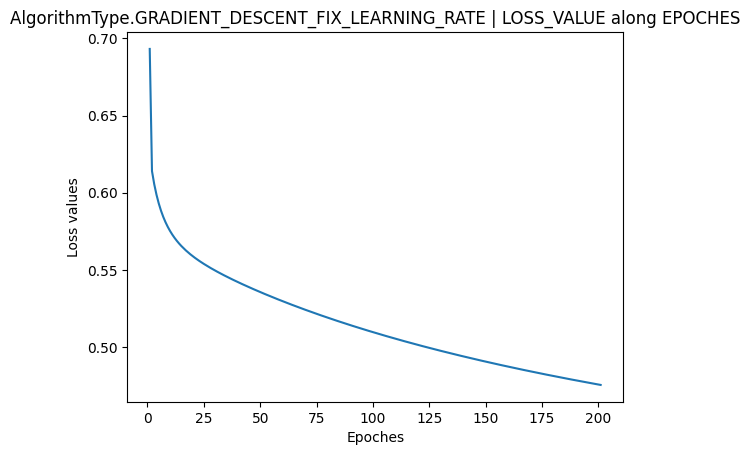

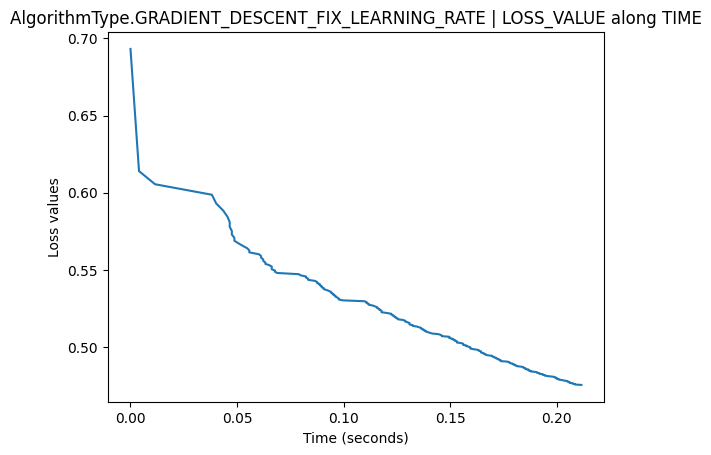

In [41]:
ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.1
MAX_EPOCHS = 200
EPS = 1e-4

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

In [395]:
# # Test GD với fix learning rate


# ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_FIX_LEARNING_RATE
# INITIAL_W = np.zeros((Xbar.shape[0], 1))
# INITIAL_LEARNING_RATE = [1, 0.5, 0.45, 0.2, 0.05]
# MAX_EPOCHS = 1000
# EPS = 1e-6


# # ADDITIONAL PARAMETERS
# ALGORITHM_TYPE.value

# for i in range(len(INITIAL_LEARNING_RATE)):
#     (
#         GRADIENT_DESCENT_FIX_LEARNING_RATE_w,
#         GRADIENT_DESCENT_FIX_LEARNING_RATE_loss_value,
#         GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
#         GRADIENT_DESCENT_FIX_LEARNING_RATE_w_tith_time,
#     ) = one_for_all(
#         algorithm_type=ALGORITHM_TYPE,
#         Xbar=Xbar,
#         y=y,
#         cost=cost,
#         grad=grad,
#         initial_w=INITIAL_W,
#         initial_learning_rate=INITIAL_LEARNING_RATE[i],
#         algorithm_name=ALGORITHM_TYPE.name,
#         max_epochs=MAX_EPOCHS,
#         eps=EPS,
#         marker="*",
#     )

### 5.5. GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss values: 0.572825
Initial learning rate: 1
Runtime: 99.964063 seconds
Additional parameters: {'alpha': 0.15, 'beta': 0.9}


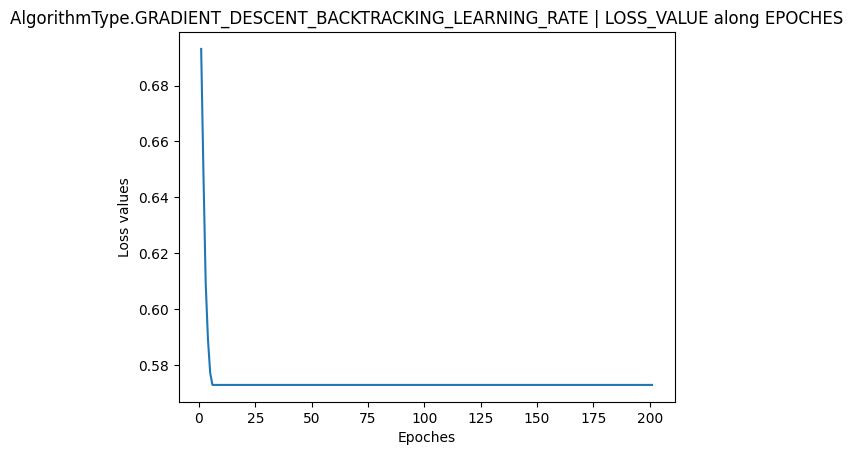

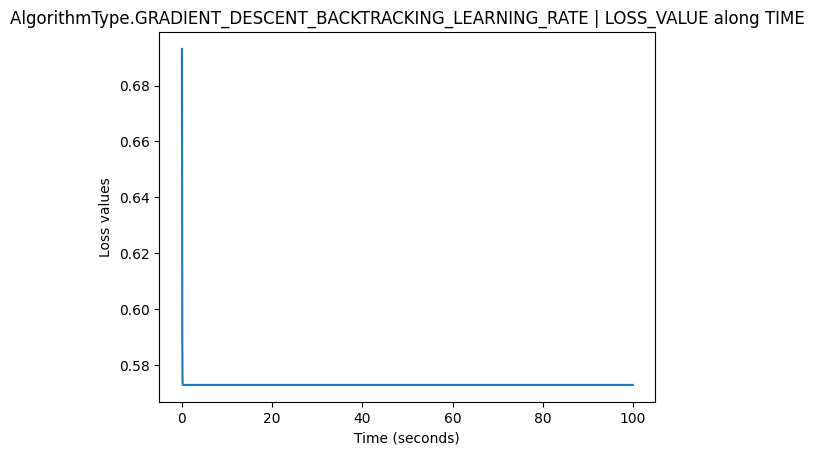

In [396]:
ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 200
EPS = 1e-4

ALPHA = 0.15
BETA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA


result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

In [397]:
# ## Test GD backtracking

# ALGORITHM_TYPE = AlgorithmType.GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
# INITIAL_W = np.zeros((Xbar.shape[0], 1))
# INITIAL_LEARNING_RATE = 1
# MAX_EPOCHS = 200
# EPS = 1e-6

# parameter_sets = [
#     {"ALPHA": 0.1, "BETA": 0.7},
#     {"ALPHA": 0.3, "BETA": 0.8},
#     {"ALPHA": 0.5, "BETA": 0.9},
# ]


# for params in parameter_sets:
#     ALPHA = params["ALPHA"]
#     BETA = params["BETA"]

#     # ADDITIONAL PARAMETERS
#     ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value
#     ADDITIONAL_PARAMETERS["alpha"] = ALPHA
#     ADDITIONAL_PARAMETERS["beta"] = BETA

#     (
#         GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w,
#         GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_loss_value,
#         GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
#         GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w_tith_time,
#     ) = one_for_all(
#         algorithm_type=ALGORITHM_TYPE,
#         Xbar=Xbar,
#         y=y,
#         cost=cost,
#         grad=grad,
#         initial_w=INITIAL_W,
#         initial_learning_rate=INITIAL_LEARNING_RATE,
#         algorithm_name=ALGORITHM_TYPE.name,
#         max_epochs=MAX_EPOCHS,
#         eps=EPS,
#         marker="*",
#         additional_parameters=ADDITIONAL_PARAMETERS,
#     )

### 5.6. STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE - randomized

STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
Best loss values: 0.425213
Initial learning rate: 0.03
Number of epochs ran/Max epoches: 187/500
Runtime: 21.819120 seconds
Additional parameters: {'batch_size': 1, 'rule': 0, 'random_seed': 10}


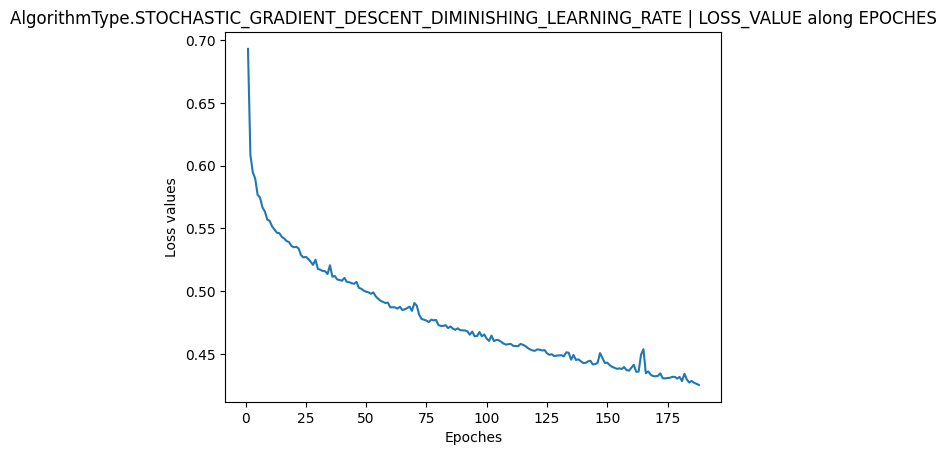

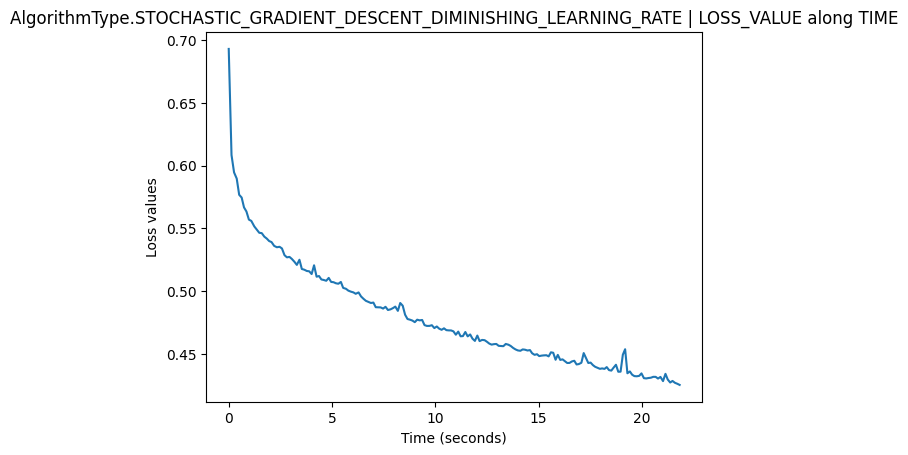

In [78]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.03
MAX_EPOCHS = 500
EPS = 1e-4

BATCH_SIZE = 1
RULE = 0
RANDOM_SEED = 10


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

In [399]:
# ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
# INITIAL_W = np.zeros((Xbar.shape[0], 1))
# # INITIAL_LEARNING_RATE = 0.01
# MAX_EPOCHS = 500
# EPS = 1e-6

# # BATCH_SIZE = 1
# RULE = 0
# RANDOM_SEED = 10
# learning_rates = [1, 0.01, 0.1]
# batch_sizes = [1, 10, 50]


# for lr in learning_rates:
#     for batch_size in batch_sizes:
#         ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

#         ADDITIONAL_PARAMETERS["batch_size"] = batch_size
#         ADDITIONAL_PARAMETERS["rule"] = RULE
#         ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

#         (
#             STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_w,
#             STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_loss_value,
#             STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_time_array,
#             STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_w_tith_time,
#         ) = one_for_all(
#             algorithm_type=ALGORITHM_TYPE,
#             Xbar=Xbar,
#             y=y,
#             cost=cost,
#             grad=grad,
#             initial_w=INITIAL_W,
#             initial_learning_rate=lr,
#             algorithm_name=ALGORITHM_TYPE,
#             max_epochs=MAX_EPOCHS,
#             eps=EPS,
#             marker="*",
#             additional_parameters=ADDITIONAL_PARAMETERS,
#         )

### 5.7. STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE - cyclic

STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
Best loss values: 0.230019
Initial learning rate: 1
Runtime: 46.195798 seconds
Additional parameters: {'batch_size': 1, 'rule': 1, 'random_seed': 10}


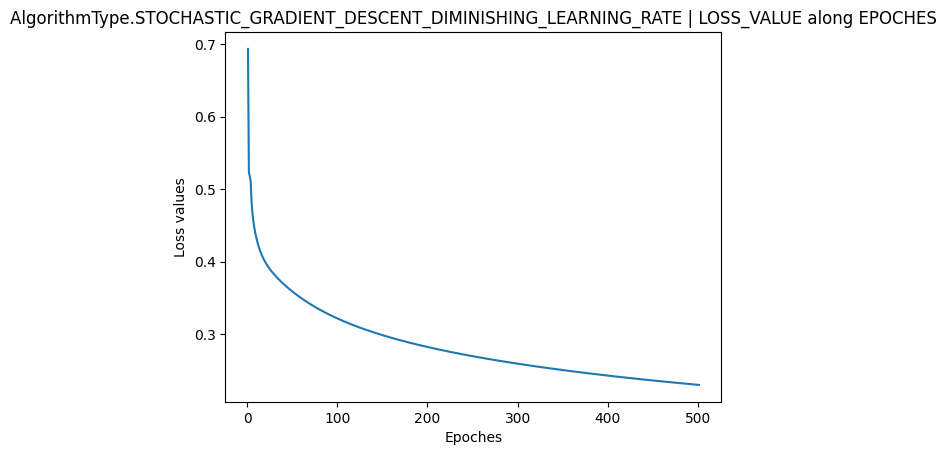

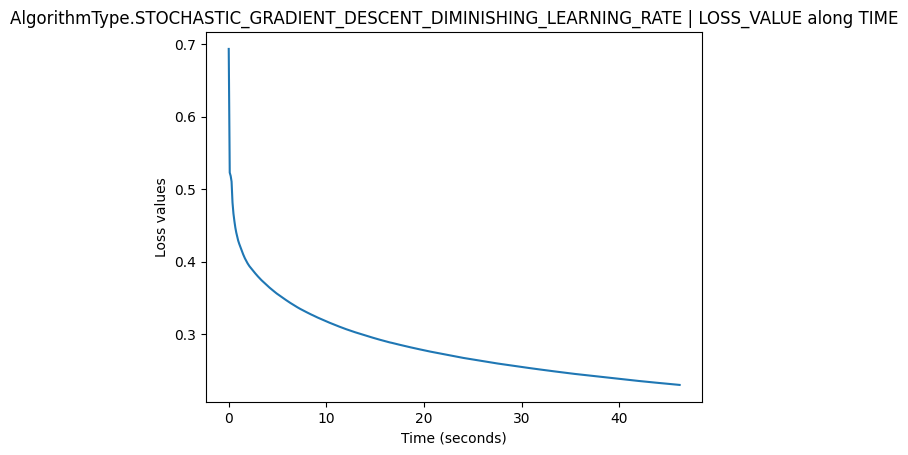

In [400]:
ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 500
EPS = 1e-4

BATCH_SIZE = 1
RULE = 1
RANDOM_SEED = 10


# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

In [401]:
# ALGORITHM_TYPE = AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE
# INITIAL_W = np.zeros((Xbar.shape[0], 1))
# INITIAL_LEARNING_RATE = [0.5, 1]
# MAX_EPOCHS = 500
# EPS = 1e-6

# BATCH_SIZE = [1, 5, 10, 50]
# RULE = 1
# RANDOM_SEED = 10

# for lr in INITIAL_LEARNING_RATE:
#     for bs in BATCH_SIZE:
#         # ADDITIONAL PARAMETERS
#         ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

#         ADDITIONAL_PARAMETERS["batch_size"] = bs
#         ADDITIONAL_PARAMETERS["rule"] = RULE
#         ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED

#         (
#             STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_w,
#             STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_loss_value,
#             STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_time_array,
#             STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_w_tith_time,
#         ) = one_for_all(
#             algorithm_type=ALGORITHM_TYPE,
#             Xbar=Xbar,
#             y=y,
#             cost=cost,
#             grad=grad,
#             initial_w=INITIAL_W,
#             initial_learning_rate=lr,
#             algorithm_name=ALGORITHM_TYPE,
#             max_epochs=MAX_EPOCHS,
#             eps=EPS,
#             marker="*",
#             additional_parameters=ADDITIONAL_PARAMETERS,
#         )

### 5.8. STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE - randomized

STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
Best loss values: 0.566784
Initial learning rate: 1
Runtime: 39.409638 seconds
Additional parameters: {'batch_size': 500, 'rule': 0, 'random_seed': 10, 'alpha': 0.15, 'beta': 0.9}


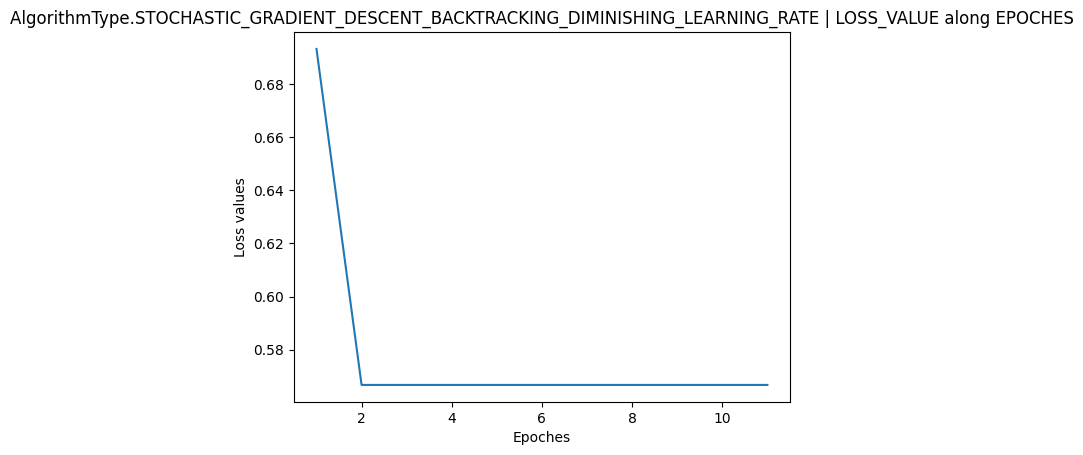

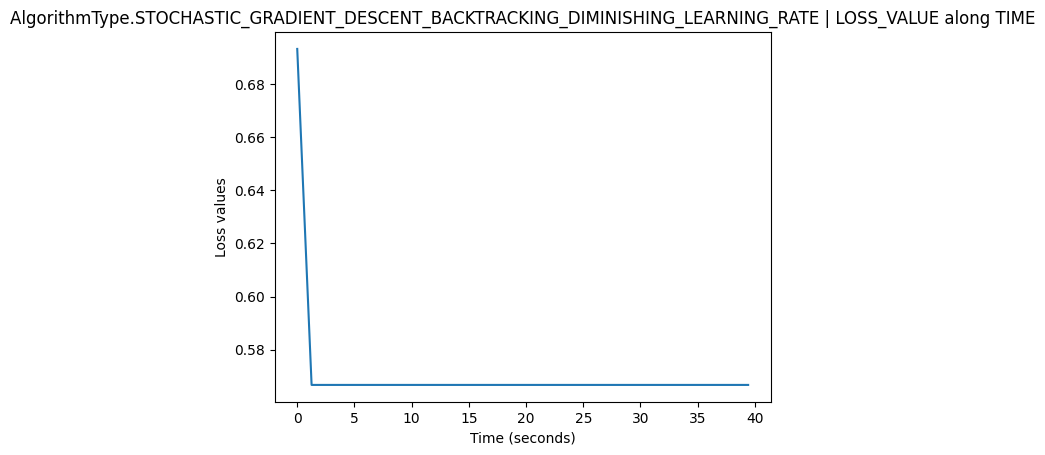

In [402]:
ALGORITHM_TYPE = (
    AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
)
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 10
EPS = 1e-4

BATCH_SIZE = 500
RULE = 0
RANDOM_SEED = 10
ALPHA = 0.15
BETA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

### 5.9. STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE - cyclic

STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
Best loss values: 0.576352
Initial learning rate: 1
Runtime: 21.703707 seconds
Additional parameters: {'batch_size': 500, 'rule': 1, 'random_seed': 10, 'alpha': 0.25, 'beta': 0.8}


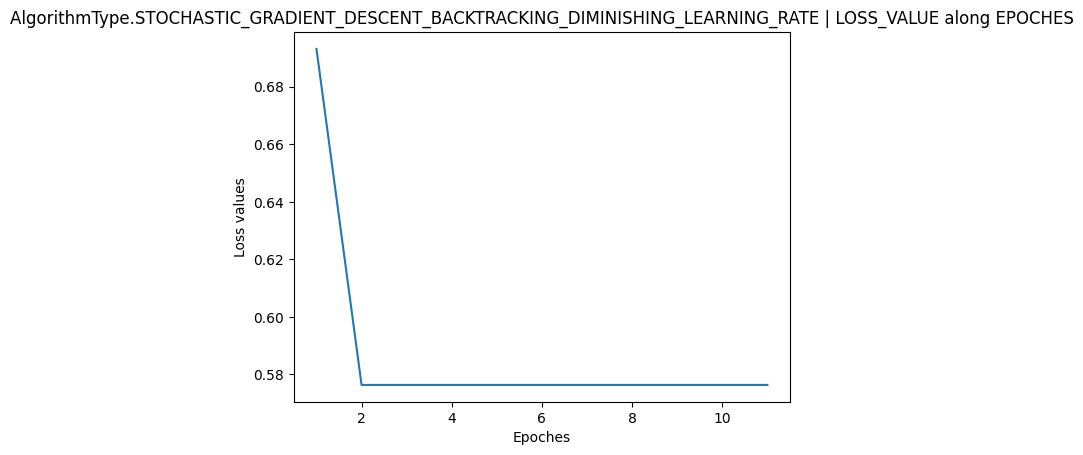

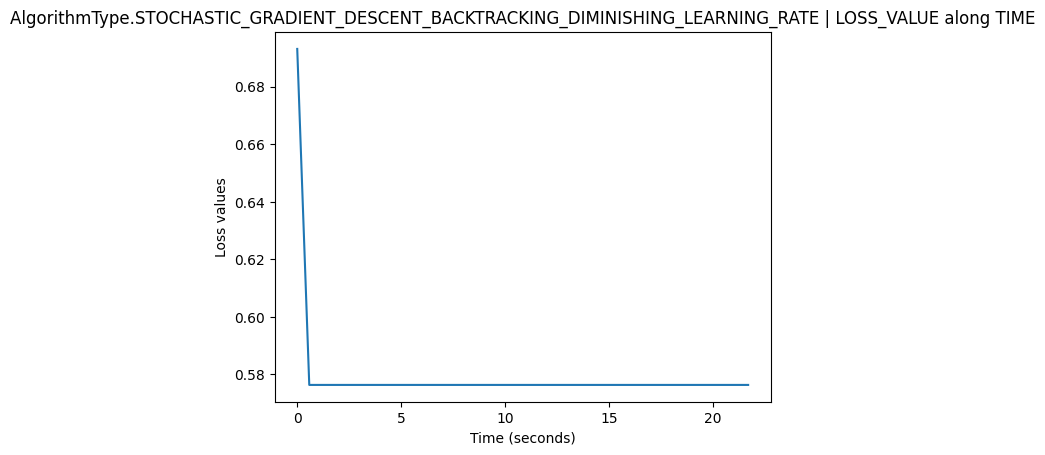

In [403]:
ALGORITHM_TYPE = (
    AlgorithmType.STOCHASTIC_GRADIENT_DESCENT_BACKTRACKING_DIMINISHING_LEARNING_RATE
)
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 10
EPS = 1e-4

BATCH_SIZE = 500
RULE = 1
RANDOM_SEED = 10
ALPHA = 0.25
BETA = 0.8

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["batch_size"] = BATCH_SIZE
ADDITIONAL_PARAMETERS["rule"] = RULE
ADDITIONAL_PARAMETERS["random_seed"] = RANDOM_SEED
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

### 5.10. MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE

MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss values: 0.410819
Initial learning rate: 1
Runtime: 0.114702 seconds
Additional parameters: {'gamma': 0.9}


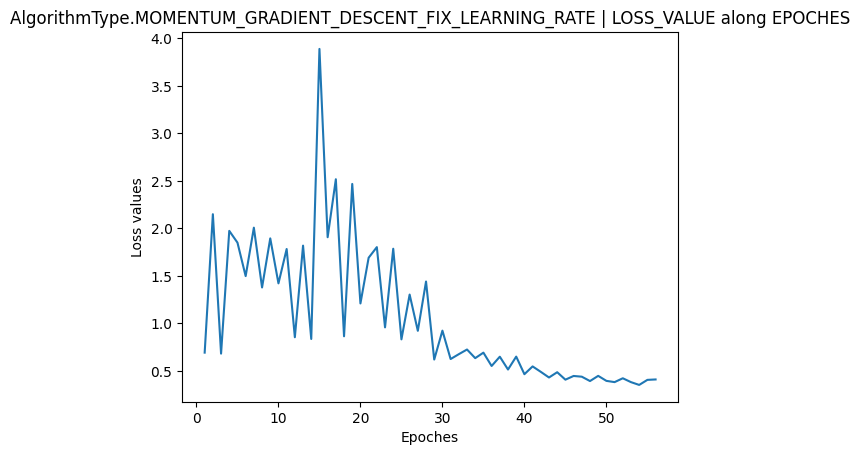

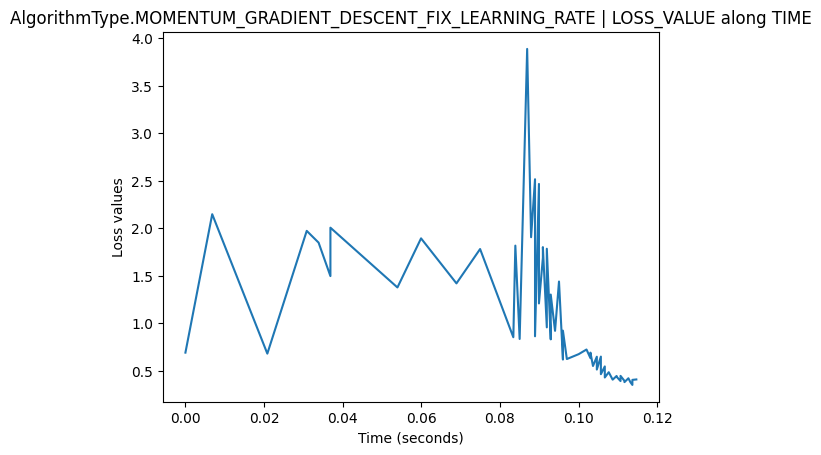

In [404]:
ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 500
EPS = 1e-4

GAMMA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["gamma"] = GAMMA

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

In [405]:
# learning_rates = [0.1, 1, 0.5, 0.01]
# gammas = [0.5, 0.9, 0.2]

# ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE
# INITIAL_W = np.zeros((Xbar.shape[0], 1))
# # INITIAL_LEARNING_RATE = 1
# MAX_EPOCHS = 500
# EPS = 1e-6

# for lr in learning_rates:
#     for gamma in gammas:
#         ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

#         ADDITIONAL_PARAMETERS["gamma"] = gamma

#         (
#             MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_w,
#             MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_loss_value,
#             MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
#             MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_w_tith_time,
#         ) = one_for_all(
#             algorithm_type=ALGORITHM_TYPE,
#             Xbar=Xbar,
#             y=y,
#             cost=cost,
#             grad=grad,
#             initial_w=INITIAL_W,
#             initial_learning_rate=lr,
#             algorithm_name=ALGORITHM_TYPE,
#             max_epochs=MAX_EPOCHS,
#             eps=EPS,
#             marker="*",
#             additional_parameters=ADDITIONAL_PARAMETERS,
#         )

### 5.11. MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss values: 0.564613
Initial learning rate: 1
Runtime: 42.110039 seconds
Additional parameters: {'gamma': 0.6, 'alpha': 0.3, 'beta': 0.5}


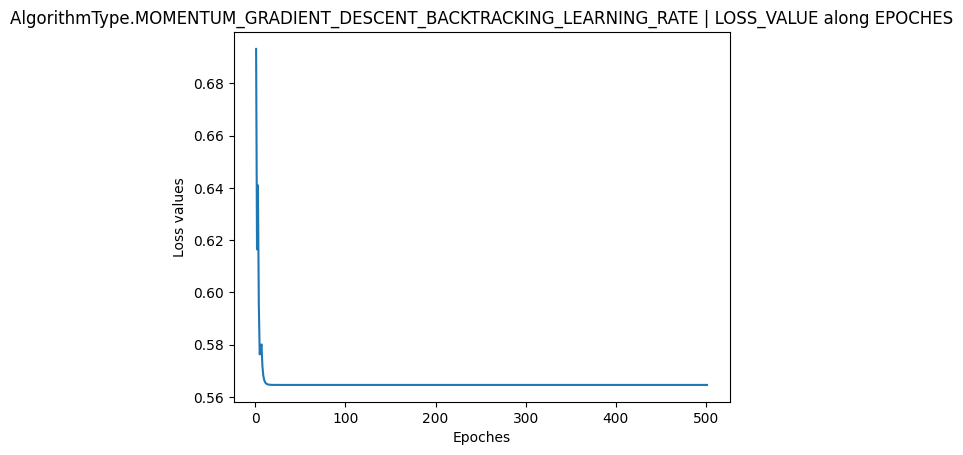

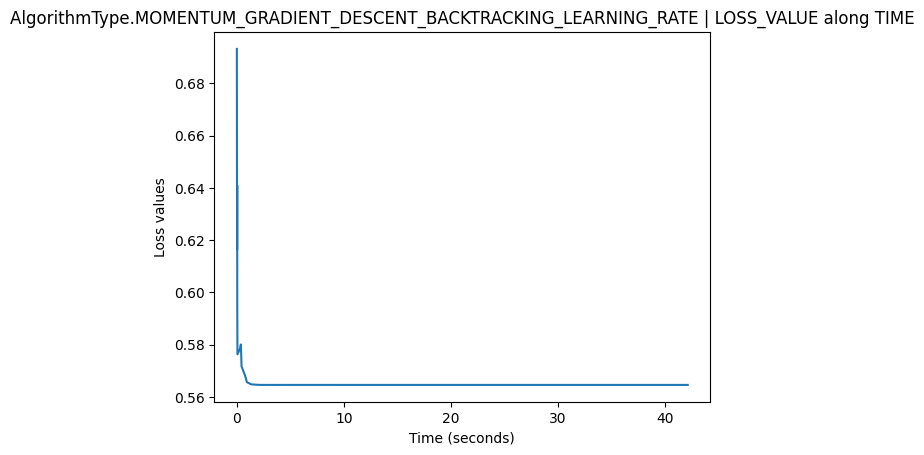

In [406]:
ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 1
MAX_EPOCHS = 500
EPS = 1e-4

GAMMA = 0.6
ALPHA = 0.3
BETA = 0.5

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["gamma"] = GAMMA
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

In [407]:
# ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
# INITIAL_W = np.zeros((Xbar.shape[0], 1))
# INITIAL_LEARNING_RATE = [1,1.5]
# MAX_EPOCHS = 500
# EPS = 1e-6

# GAMMA = 0.9
# ALPHA = [0.3, 0.1, 0.5]
# BETA = [0.8, 0.5]

# for a in ALPHA:
#     for b in BETA:
#         for lr in INITIAL_LEARNING_RATE:

#             # ADDITIONAL PARAMETERS
#             ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

#             ADDITIONAL_PARAMETERS["gamma"] = GAMMA
#             ADDITIONAL_PARAMETERS["alpha"] = a
#             ADDITIONAL_PARAMETERS["beta"] = b

#             (
#                 MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w,
#                 MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE__loss_value,
#                 MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
#                 MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w_tith_time,
#             ) = one_for_all(
#                 algorithm_type=ALGORITHM_TYPE,
#                 Xbar=Xbar,
#                 y=y,
#                 cost=cost,
#                 grad=grad,
#                 initial_w=INITIAL_W,
#                 initial_learning_rate=lr,
#                 algorithm_name=ALGORITHM_TYPE,
#                 max_epochs=MAX_EPOCHS,
#                 eps=EPS,
#                 marker="*",
#                 additional_parameters=ADDITIONAL_PARAMETERS,
#             )

### 5.12. NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE

NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
Best loss values: 0.216348
Initial learning rate: 0.5
Runtime: 0.530998 seconds
Additional parameters: {'NAG_gamma': 0.9}


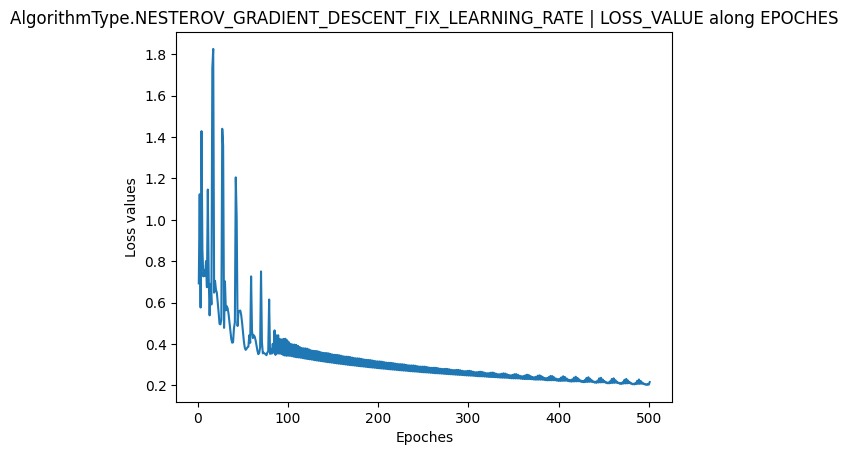

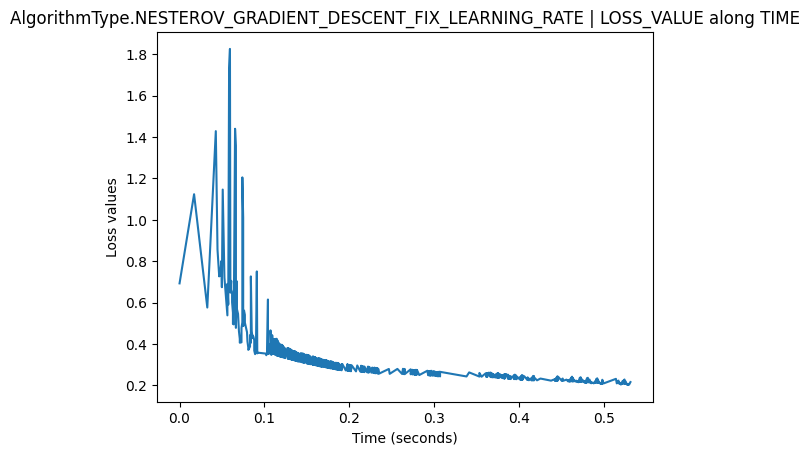

In [408]:
ALGORITHM_TYPE = AlgorithmType.NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.5
MAX_EPOCHS = 500
EPS = 1e-4

GAMMA = 0.9

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["NAG_gamma"] = GAMMA

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

### 5.13. NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE

NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
Best loss values: 0.568214
Initial learning rate: 0.5
Runtime: 19.498674 seconds
Additional parameters: {'NAG_gamma': 0.8, 'alpha': 0.5, 'beta': 0.8}


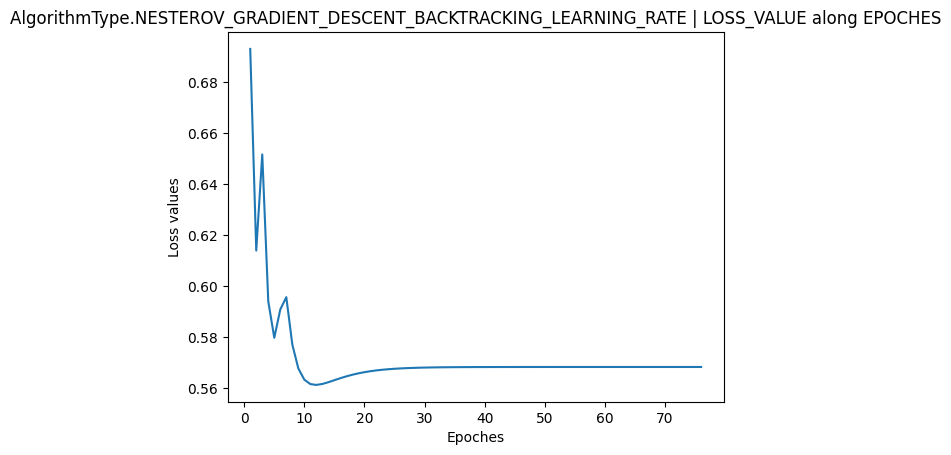

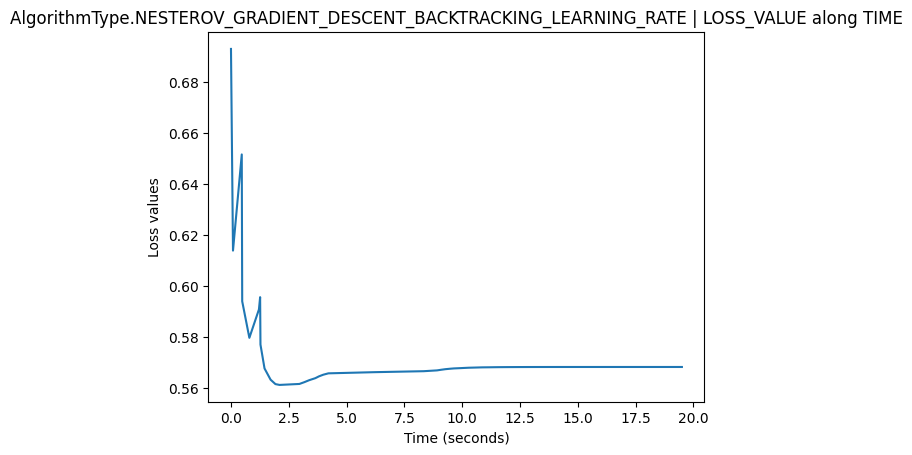

In [410]:
ALGORITHM_TYPE = AlgorithmType.NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
INITIAL_W = np.zeros((Xbar.shape[0], 1))
INITIAL_LEARNING_RATE = 0.5
MAX_EPOCHS = 75
EPS = 1e-4

GAMMA = 0.8
ALPHA = 0.5
BETA = 0.8

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

ADDITIONAL_PARAMETERS["NAG_gamma"] = GAMMA
ADDITIONAL_PARAMETERS["alpha"] = ALPHA
ADDITIONAL_PARAMETERS["beta"] = BETA

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
        additional_parameters=ADDITIONAL_PARAMETERS,
    )
)

result_set.add_result(result)

### 5.14. NEWTON

NEWTON
Best loss values: 0.076025
Number of epochs ran/Max epoches: 2/500
Runtime: 0.312720 seconds
Additional parameters: {'test': 1}


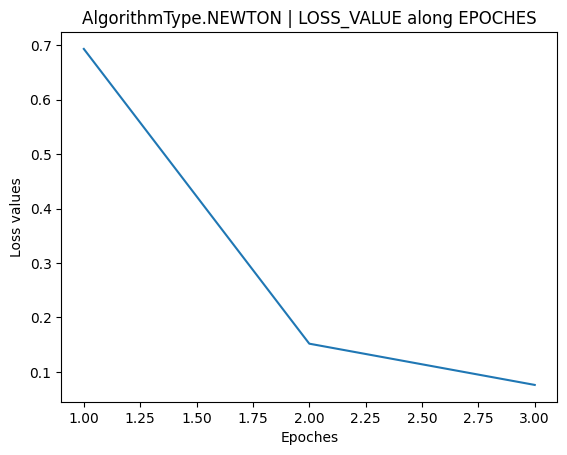

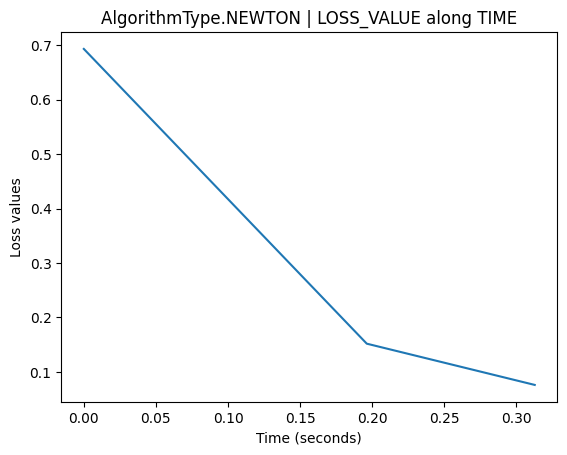

In [137]:
ALGORITHM_TYPE = AlgorithmType.NEWTON
INITIAL_W = np.zeros((Xbar.shape[0], 1))
MAX_EPOCHS = 500
EPS = 1e-4

# ADDITIONAL PARAMETERS
ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

result = Result()

result.add_parameter(
    algorithm_type=ALGORITHM_TYPE,
    initial_w=INITIAL_W,
    initial_learning_rate=INITIAL_LEARNING_RATE,
    max_epochs=MAX_EPOCHS,
    eps=EPS,
    additional_parameters=ADDITIONAL_PARAMETERS,
)

result.add_one_for_all_result(
    one_for_all(
        algorithm_type=ALGORITHM_TYPE,
        Xbar=Xbar,
        y=y,
        cost=cost,
        grad=grad,
        initial_w=INITIAL_W,
        initial_learning_rate=INITIAL_LEARNING_RATE,
        algorithm_name=ALGORITHM_TYPE.name,
        max_epochs=MAX_EPOCHS,
        eps=EPS,
        additional_parameters=ADDITIONAL_PARAMETERS,
        grad_2=grad_2,
    )
)

result_set.add_result(result)

## 6. Save and load ResultSets

### 6.1 Save

In [61]:
result_set.compile_dataframe()
result_set.dataframe

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
0,0,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.10,200,0.0001,{},"[[0.16287180104939802], [0.3786218397850307], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.0040013790130615234, 0.01154160499572753...","[0.6931471805599466, 0.6140431795376569, 0.605...",0.211522,200,0.475599
1,1,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.00,100,0.0001,{},"[[0.6622230424166727], [1.0078150672484858], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.024599552154541016, 0.04364347457885742,...","[0.6931471805599466, 2.150344558643357, 3.0394...",0.415158,100,2.109211
2,2,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.10,100,0.0001,{},"[[0.09897605020083643], [0.26785976325120164],...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.023057222366333008, 0.03408360481262207,...","[0.6931471805599466, 0.6140431795376569, 0.605...",0.385502,100,0.509335
3,3,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.10,1000,0.0001,{},"[[0.2853524007509151], [0.49294124660631333], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.02402973175048828, 0.03605294227600098, ...","[0.6931471805599466, 0.6140431795376569, 0.605...",1.351181,425,0.434617
4,4,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.20,1000,0.0001,{},"[[0.2850186693679892], [0.4929879568449872], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.04552865028381348, 0.050458669662475586,...","[0.6931471805599466, 0.6614799933659269, 0.598...",0.199151,212,0.434708
5,5,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.50,1000,0.0001,{},"[[1.392326525938602], [0.4214206470821128], [-...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.009964227676391602, 0.014975309371948242...","[0.6931471805599466, 1.1237707354678768, 1.232...",0.945392,1000,0.340395
6,6,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.50,10000,0.0001,{},"[[1.6225823032555413], [0.3903454816988365], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.03281998634338379, 0.04132437705993652, ...","[0.6931471805599466, 1.1237707354678768, 1.232...",2.758842,1947,0.263365
7,7,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.80,10000,0.0001,{},"[[2.0855468789651295], [0.44409754259954204], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.015567302703857422, 0.01856541633605957,...","[0.6931471805599466, 1.7288486439038315, 2.340...",6.424509,7087,0.148182
8,8,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.00,10000,0.0001,{},"[[2.1948715044299214], [0.45626361047812486], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.007047891616821289, 0.026099443435668945...","[0.6931471805599466, 2.150344558643357, 3.0394...",11.445750,9500,0.118800
9,9,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",1.30,12000,0.0001,{},"[[2.7818063521627994], [0.5945415594057147], [...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.03506731986999512, 0.04008293151855469, ...","[0.6931471805599466, 2.7886767843018423, 4.029...",7.324941,8009,0.113751


In [63]:
result_set.save_dataframe("test")

### 6.2 Load

In [540]:
LOADED_DATAFRAME = []

In [541]:
FOLDER_PATH = "./result/"

In [542]:
def load_result_from_folder(folder_path: str):
    if not os.path.isdir(FOLDER_PATH):
        raise Exception("Input path is not a directory!")
    
    global LOADED_DATAFRAME
    
    excel_files = glob.glob(folder_path + "*.xlsx")
    
    dfs = []
    
    for file in excel_files:
        df = pd.read_excel(file)
        dfs.append(df)
    
    LOADED_DATAFRAME = pd.concat(dfs, ignore_index=True)
    
    LOADED_DATAFRAME

In [543]:
load_result_from_folder(FOLDER_PATH)

In [544]:
LOADED_DATAFRAME

,id,algorithm_type,initial_w,initial_learning_rate,max_epochs,eps,additional_parameters,w_solution,epoch_list,time_each_epoch_list,loss_value_epoch_list,runtime,epoch_count,best_loss_value
0,0,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.1,200,0.0001,{},"[[0.16287180104939802], [0.3786218397850307], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.036081552505493164, 0.04211616516113281,...","[0.6931471805599466, 0.6140431795376569, 0.605...",0.321896,200,0.475599
1,0,GRADIENT_DESCENT_FIX_LEARNING_RATE,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",0.1,200,0.0001,{},"[[0.16287180104939802], [0.3786218397850307], ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0.036081552505493164, 0.04211616516113281,...","[0.6931471805599466, 0.6140431795376569, 0.605...",0.321896,200,0.475599


In [545]:
hello = ast.literal_eval(LOADED_DATAFRAME["loss_value_epoch_list"][0])
hello

[0.6931471805599466,
 0.6140431795376569,
 0.6055254938726997,
 0.5987295041977294,
 0.5931148517944326,
 0.5884049424975931,
 0.5844000572970276,
 0.5809518672892687,
 0.5779484680140573,
 0.5753042559652456,
 0.5729529147712259,
 0.5708424756531324,
 0.5689317855746124,
 0.5671879453534878,
 0.5655844260412467,
 0.5640996663789869,
 0.5627160161095514,
 0.5614189311231912,
 0.5601963541816766,
 0.5590382339366426,
 0.5579361480897189,
 0.556883005746556,
 0.5558728105459924,
 0.5549004708295565,
 0.5539616465127641,
 0.5530526248071792,
 0.5521702187815487,
 0.5513116841226373,
 0.5504746504889938,
 0.5496570646341088,
 0.5488571430740389,
 0.5480733325353692,
 0.5473042767765227,
 0.546548788654015,
 0.5458058265238986,
 0.5450744742412559,
 0.54435392415761,
 0.5436434626254734,
 0.5429424576069489,
 0.5422503480539684,
 0.5415666347849718,
 0.5408908726293525,
 0.5402226636489829,
 0.5395616512772683,
 0.5389075152418188,
 0.5382599671579741,
 0.5376187466979822,
 0.53698361825520

## 6. Algorithms comparison

### 6.1. SKLEARN: SGDClassifier | log loss

SGDClassifier(eta0=0.005, learning_rate='constant', loss='log_loss', max_iter=1,
              random_state=42, tol=None, warm_start=True)
Loss value: 0.113883
Runtime: 19.278721 s


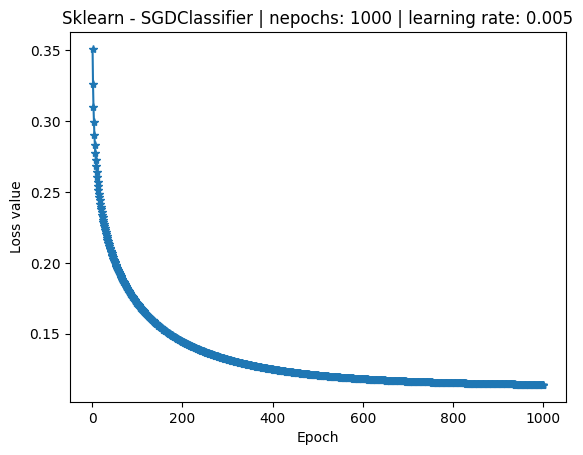

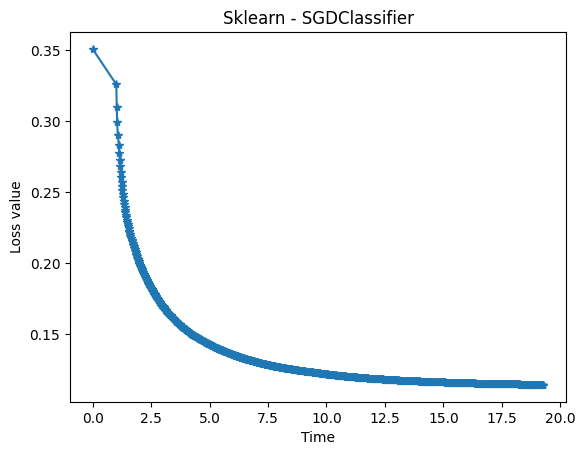

In [251]:
NUMBER_OF_EPOCHS = 1000
INITIAL_LEARNING_RATE = 0.005

X_fit = X.T

sklearn_SGDClassifier_model = SGDClassifier(
    loss="log_loss",
    learning_rate="constant",
    eta0=INITIAL_LEARNING_RATE,
    max_iter=1,
    tol=None,
    random_state=42,
    warm_start=True,
)

sklearn_SGDClassifier_model_time_array_log_loss_values = []

sklearn_SGDClassifier_model_time_array = [0]
start_time = time.time()
time_step = 1

sklearn_SGDClassifier_model_epoch_count = [1]
for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
    sklearn_SGDClassifier_model.fit(X_fit, y)
    y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
    loss = log_loss(y, y_prob)
    sklearn_SGDClassifier_model_time_array_log_loss_values.append(loss)

    current_time = time.time()
    if current_time - start_time >= time_step:
        sklearn_SGDClassifier_model_time_array.append(current_time - start_time)

    sklearn_SGDClassifier_model_epoch_count.append(
        sklearn_SGDClassifier_model_epoch_count[-1] + 1
    )

end_time = time.time()

# Print result
print(f"{sklearn_SGDClassifier_model}")
print(f"Loss value: {sklearn_SGDClassifier_model_time_array_log_loss_values[-1]:.6f}")
print(f"Runtime: {(end_time - start_time):.6f} s")

# Plot loss value along epoch
plt.plot(range(1, NUMBER_OF_EPOCHS + 1), sklearn_SGDClassifier_model_time_array_log_loss_values, marker="*")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title(
    f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
)
plt.show()

# Plot loss value along time
limit = min(len(sklearn_SGDClassifier_model_time_array), len(sklearn_SGDClassifier_model_time_array_log_loss_values))
plt.plot(sklearn_SGDClassifier_model_time_array[:limit], sklearn_SGDClassifier_model_time_array_log_loss_values[:limit], marker="*")
plt.xlabel("Time")
plt.ylabel("Loss value")
plt.title(f"Sklearn - SGDClassifier")
plt.show()

SGDClassifier(eta0=0.01, learning_rate='constant', loss='log_loss', max_iter=1,
              random_state=42, tol=None, warm_start=True)
Loss value: 0.112774
Runtime: 17.974379 s


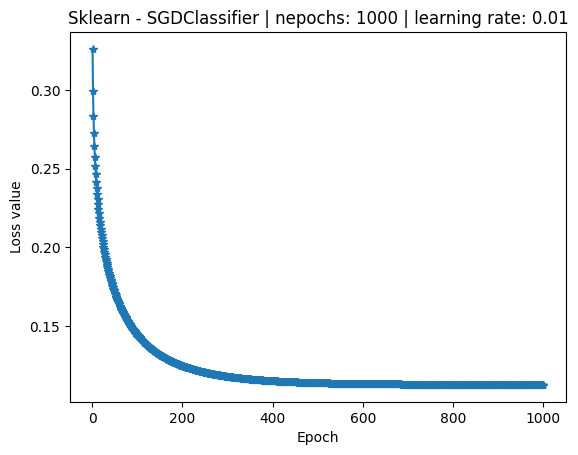

In [152]:
NUMBER_OF_EPOCHS = 1000
INITIAL_LEARNING_RATE = 0.01

X_fit = X.T

sklearn_SGDClassifier_model = SGDClassifier(
    loss="log_loss",
    learning_rate="constant",
    eta0=INITIAL_LEARNING_RATE,
    max_iter=1,
    tol=None,
    random_state=42,
    warm_start=True,
)

log_loss_values = []


start_time = time.time()

for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
    sklearn_SGDClassifier_model.fit(X_fit, y)
    y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
    loss = log_loss(y, y_prob)
    log_loss_values.append(loss)

end_time = time.time()

# Print result
print(f"{sklearn_SGDClassifier_model}")
print(f"Loss value: {log_loss_values[-1]:.6f}")
print(f"Runtime: {(end_time - start_time):.6f} s")

# Plot the loss curve
plt.plot(range(1, NUMBER_OF_EPOCHS + 1), log_loss_values, marker="*")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title(
    f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
)
plt.show()

SGDClassifier(eta0=0.02, learning_rate='constant', loss='log_loss', max_iter=1,
              random_state=42, tol=None, warm_start=True)
Loss value: 0.113111
Runtime: 17.805003 s


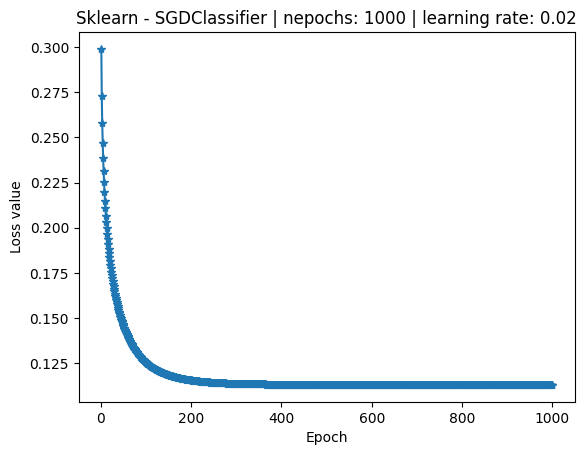

In [153]:
NUMBER_OF_EPOCHS = 1000
INITIAL_LEARNING_RATE = 0.02

X_fit = X.T

sklearn_SGDClassifier_model = SGDClassifier(
    loss="log_loss",
    learning_rate="constant",
    eta0=INITIAL_LEARNING_RATE,
    max_iter=1,
    tol=None,
    random_state=42,
    warm_start=True,
)

log_loss_values = []


start_time = time.time()

for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
    sklearn_SGDClassifier_model.fit(X_fit, y)
    y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
    loss = log_loss(y, y_prob)
    log_loss_values.append(loss)

end_time = time.time()

# Print result
print(f"{sklearn_SGDClassifier_model}")
print(f"Loss value: {log_loss_values[-1]:.6f}")
print(f"Runtime: {(end_time - start_time):.6f} s")

# Plot the loss curve
plt.plot(range(1, NUMBER_OF_EPOCHS + 1), log_loss_values, marker="*")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title(
    f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
)
plt.show()

SGDClassifier(eta0=0.05, learning_rate='constant', loss='log_loss', max_iter=1,
              random_state=42, tol=None, warm_start=True)
Loss value: 0.119425
Runtime: 17.801031 s


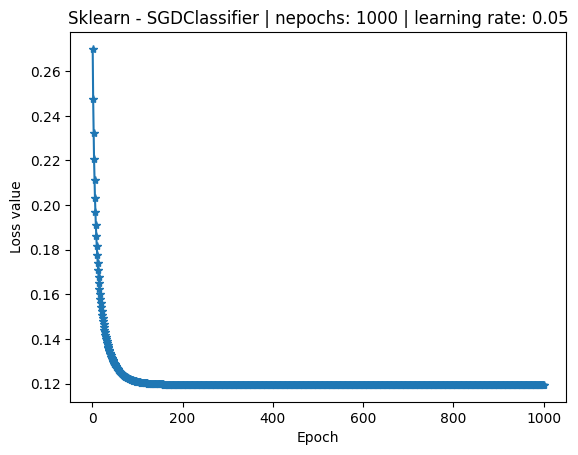

In [154]:
NUMBER_OF_EPOCHS = 1000
INITIAL_LEARNING_RATE = 0.05

X_fit = X.T

sklearn_SGDClassifier_model = SGDClassifier(
    loss="log_loss",
    learning_rate="constant",
    eta0=INITIAL_LEARNING_RATE,
    max_iter=1,
    tol=None,
    random_state=42,
    warm_start=True,
)

log_loss_values = []


start_time = time.time()

for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
    sklearn_SGDClassifier_model.fit(X_fit, y)
    y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
    loss = log_loss(y, y_prob)
    log_loss_values.append(loss)

end_time = time.time()

# Print result
print(f"{sklearn_SGDClassifier_model}")
print(f"Loss value: {log_loss_values[-1]:.6f}")
print(f"Runtime: {(end_time - start_time):.6f} s")

# Plot the loss curve
plt.plot(range(1, NUMBER_OF_EPOCHS + 1), log_loss_values, marker="*")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title(
    f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
)
plt.show()

SGDClassifier(eta0=0.1, learning_rate='constant', loss='log_loss', max_iter=1,
              random_state=42, tol=None, warm_start=True)
Loss value: 0.125859
Runtime: 17.848480 s


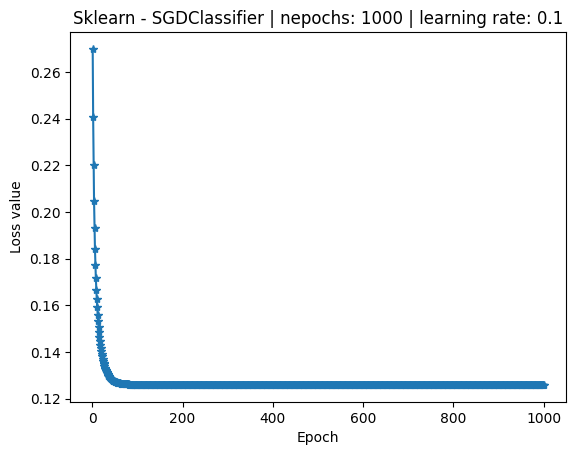

In [155]:
NUMBER_OF_EPOCHS = 1000
INITIAL_LEARNING_RATE = 0.1

X_fit = X.T

sklearn_SGDClassifier_model = SGDClassifier(
    loss="log_loss",
    learning_rate="constant",
    eta0=INITIAL_LEARNING_RATE,
    max_iter=1,
    tol=None,
    random_state=42,
    warm_start=True,
)

log_loss_values = []


start_time = time.time()

for epoch in range(1, NUMBER_OF_EPOCHS + 1):  # Train for NUMBER_OF_EPOCHS epochs
    sklearn_SGDClassifier_model.fit(X_fit, y)
    y_prob = sklearn_SGDClassifier_model.predict_proba(X_fit)
    loss = log_loss(y, y_prob)
    log_loss_values.append(loss)

end_time = time.time()

# Print result
print(f"{sklearn_SGDClassifier_model}")
print(f"Loss value: {log_loss_values[-1]:.6f}")
print(f"Runtime: {(end_time - start_time):.6f} s")

# Plot the loss curve
plt.plot(range(1, NUMBER_OF_EPOCHS + 1), log_loss_values, marker="*")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title(
    f"Sklearn - SGDClassifier | nepochs: {NUMBER_OF_EPOCHS} | learning rate: {INITIAL_LEARNING_RATE}"
)
plt.show()

In [43]:
# ALGORITHM_TYPE = AlgorithmType.MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE
# INITIAL_W = np.zeros((Xbar.shape[0], 1))
# INITIAL_LEARNING_RATE = 1
# MAX_EPOCHS = 500
# EPS = 1e-6

# GAMMA = 0.9
# ALPHA = 0.3
# BETA = 0.5

# # ADDITIONAL PARAMETERS
# ADDITIONAL_PARAMETERS = ALGORITHM_TYPE.value

# ADDITIONAL_PARAMETERS["gamma"] = GAMMA
# ADDITIONAL_PARAMETERS["alpha"] = ALPHA
# ADDITIONAL_PARAMETERS["beta"] = BETA

# (
#     MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_w,
#     MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_loss_value,
#     MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
#     MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_epoch_count,
# ) = one_for_all(
#     algorithm_type=ALGORITHM_TYPE,
#     Xbar=Xbar,
#     y=y,
#     cost=cost,
#     grad=grad,
#     initial_w=INITIAL_W,
#     initial_learning_rate=INITIAL_LEARNING_RATE,
#     algorithm_name=ALGORITHM_TYPE,
#     max_epochs=MAX_EPOCHS,
#     eps=EPS,
#     marker="*",
#     additional_parameters=ADDITIONAL_PARAMETERS,
# )

### 6.3. Build Comparer

In [260]:
def plot_algorithm_in_a_plot(
    algorithm_plots: list[AlgorithmPlot],
):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Epoch

    for algorithm in algorithm_plots:
        limit = min(len(algorithm.epoch_count), len(algorithm.loss_values))
        axs[0].plot(
            algorithm.epoch_count[:limit],
            algorithm.loss_values[:limit],
            label=f"Best {algorithm.name}",
        )

    axs[0].legend()
    axs[0].set_title("Loss value according epochs")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss value")

    for algorithm in algorithm_plots:
        limit = min(len(algorithm.time_array), len(algorithm.loss_values))
        axs[1].plot(
            algorithm.time_array[:limit],
            algorithm.loss_values[:limit],
            label=f"Best {algorithm.name}",
        )

    axs[1].legend()
    axs[1].set_title("Loss value according time")
    axs[1].set_xlabel("Time (seconds)")
    axs[1].set_ylabel("Loss value")

    plt.show()

### 6.4. Comparisons

In [286]:
algorithm_plots = []

In [287]:
SKLEARN_SGD_plot = AlgorithmPlot(
    name="SKLEARN_SGD",
    epoch_count=sklearn_SGDClassifier_model_epoch_count,
    time_array=sklearn_SGDClassifier_model_time_array,
    loss_values=sklearn_SGDClassifier_model_time_array_log_loss_values,
)

algorithm_plots.append(SKLEARN_SGD_plot)

In [288]:
GRADIENT_DESCENT_FIX_LEARNING_RATE_plot = AlgorithmPlot(
    name="GD_FIX",
    epoch_count=GRADIENT_DESCENT_FIX_LEARNING_RATE_epoch_count,
    time_array=GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
    loss_values=GRADIENT_DESCENT_FIX_LEARNING_RATE_loss_value,
)

algorithm_plots.append(GRADIENT_DESCENT_FIX_LEARNING_RATE_plot)

In [289]:
GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_plot = AlgorithmPlot(
    name="GD_BACKTRACKING",
    epoch_count=GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_epoch_count,
    time_array=GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
    loss_values=GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_loss_value,
)

algorithm_plots.append(GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_plot)

In [290]:
STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_plot = AlgorithmPlot(
    name="SGD_FIX",
    epoch_count=STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_epoch_count,
    time_array=STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_time_array,
    loss_values=STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_loss_value,
)

algorithm_plots.append(STOCHASTIC_GRADIENT_DESCENT_DIMINISHING_LEARNING_RATE_plot)

In [291]:
MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_plot = AlgorithmPlot(
    name="MOMENTUM_FIX",
    epoch_count=MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_epoch_count,
    time_array=MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
    loss_values=MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_loss_value,
)

algorithm_plots.append(MOMENTUM_GRADIENT_DESCENT_FIX_LEARNING_RATE_plot)

In [292]:
MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_plot = AlgorithmPlot(
    name="MOMENTUM_BACKTRACKING",
    epoch_count=MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_epoch_count,
    time_array=MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
    loss_values=MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_loss_value,
)

algorithm_plots.append(MOMENTUM_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_plot)

In [293]:
NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_plot = AlgorithmPlot(
    name="NESTEROV_FIX",
    epoch_count=NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_epoch_count,
    time_array=NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_time_array,
    loss_values=NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_loss_value,
)

algorithm_plots.append(NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_plot)

In [294]:
NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_plot = AlgorithmPlot(
    name="NESTEROV_BACKTRACKING",
    epoch_count=NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_epoch_count,
    time_array=NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_time_array,
    loss_values=NESTEROV_GRADIENT_DESCENT_BACKTRACKING_LEARNING_RATE_loss_value,
)

algorithm_plots.append(NESTEROV_GRADIENT_DESCENT_FIX_LEARNING_RATE_plot)

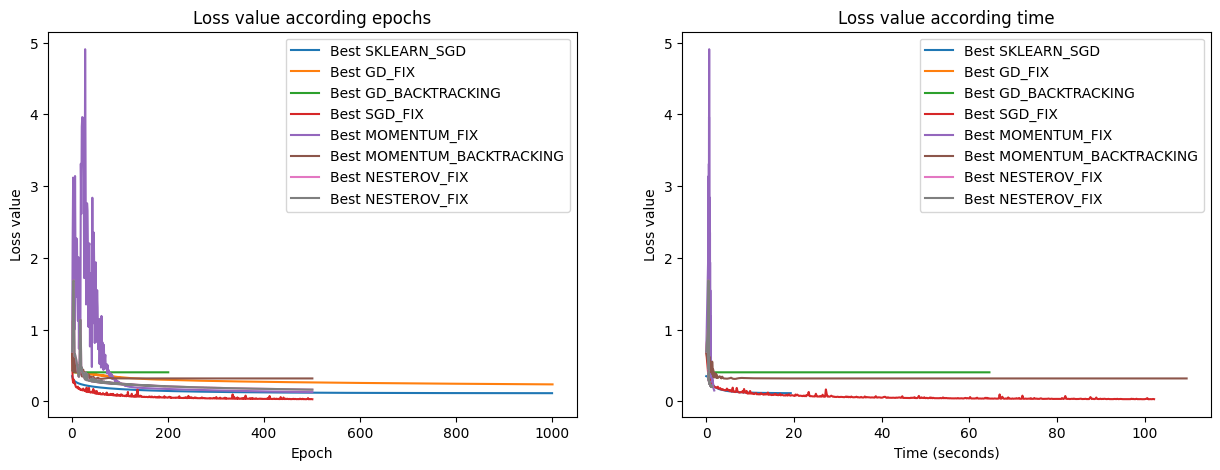

In [295]:
plot_algorithm_izn_a_plot(algorithm_plots)

## 7. Conclusion